Data visualization and results

In [289]:
###########
# Imports #
###########

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator, PercentFormatter
from adjustText import adjust_text
import plotly.graph_objects as go
import plotly.io as pio
import plotly.subplots as sp
from sklearn.decomposition import PCA
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score
from sklearn.metrics.pairwise import cosine_similarity

In [232]:
############# 
# plotting  #
#############

# ----------------------------
# Landscape2 plot function
# ----------------------------
def plot_landscape2(df, title, models, exp, party_codes, colors_models, colors_parties, exp_var, x_pts=None, y_pts=None, signs=[1, 1], pca_model=None, show=True):
    pca_df, pca_model = do_PCA(df, models, party_codes, pca_model)
    # DO plotting
    make_landscape_plot(pca_df, title, models, exp, party_codes, colors_models, colors_parties, exp_var, x_pts, y_pts, signs, show)
    return pca_df, pca_model

# ----------------------------
# PCA plot function
# ----------------------------
def do_PCA(df, models, party_codes, pca_model=None, n_components=2):
    
    columns = party_codes+models
    
    df[columns] = df[columns].fillna(0)
    df[columns] = df[columns].apply(pd.to_numeric)

    df_transposed = df[columns].transpose()
    if pca_model == None:
        pca_model = PCA(n_components=n_components)
        pca_result = pca_model.fit_transform(df_transposed)
    else:
        pca_result = pca_model.transform(df_transposed)
        
    print(len(pca_model.mean_))
    pca_df = pd.DataFrame(data=pca_result, columns=[f'PCA{i+1}' for i in range(pca_result.shape[1])], index=df_transposed.index)
    print(pca_df)
    return pca_df, pca_model

# ----------------------------
# Landscape plot function
# ----------------------------
def make_landscape_plot(pca_df, title, models, exp, party_codes, colors_models, colors_parties, exp_var, x_pts=None, y_pts=None, signs=[1, 1], show=True, xlim=None, ylim=None):
    """
    if exp == "ES":
        colors_parties = [
            "#fdbb84",  # Ciudadanos
            "#31a354",  # Más País
            "#3182bd",  # PNV
            "#de2d26",  # PP
            "#756bb1",  # PSOE
            "#e6550d",  # CUP
            "#636363",  # ERC
            "#bdbdbd",  # VOX
            "#6baed6",  # EH Bildu
            "#9ecae1"   # Junts
        ]
    else:
        # fallback or other country setup (keep if needed)
        colors_parties = ['#D91A39','#3C79C1','#0A8E3E','#18295E','#FC9A2B','#85C046','#B21D62','#064B2F','#701C44','#F75822']
    """
    print(colors_parties)
    print(colors_models)
    colors = colors_parties + colors_models
    
    plt.figure(figsize=(10, 10))  # wider and slightly shorter

    df_plot = pca_df.copy()
    
    df_plot.iloc[:, 0] = signs[0] * df_plot.iloc[:, 0] 
    df_plot.iloc[:, 1] = signs[1] * df_plot.iloc[:, 1] 
    
    texts = []
    pca_cols = df_plot.columns
    print(pca_cols)
    for idx, col in enumerate(df_plot.index):
        try:
            if df_plot.index[idx] in ['Abstain', 'Yes', 'No', 'Ran', 'Abstain/Yes/No']:
                marker_style = '^'
            elif idx >= len(df_plot.index) - len(models):
                marker_style = '*'
            else:
                marker_style = 'o'  # Default marker style (circle)

            plt.scatter(df_plot.loc[col, pca_cols[0]], df_plot.loc[col, pca_cols[1]], 
                        label=col, s=150, color=colors[idx % len(colors)], marker=marker_style)
            
            if col in ['Yes', 'No', 'Ran', 'Abstain/Yes/No']:
                x_offset, y_offset = 0.02, 0.02  # More separation
            else:
                x_offset, y_offset = -0.08, 0.08
                
            texts.append(plt.text(df_plot.loc[col, pca_cols[0]] + x_offset, df_plot.loc[col, pca_cols[1]] + y_offset, col, fontsize=8, fontweight='medium'))
        except Exception as e:
            print(f"Error plotting index {idx}: {e}")

    if xlim == None:        
        adjust_text(texts, 
                    force_text=(8, 8),#(4, 3), 
                    expand_text=(2, 2),#(0, 0), 
                    only_move={'text': 'xy'},
                    autoalign='xy'
                   )
        
    plt.xlabel(pca_cols[0], fontsize=18)
    plt.ylabel(pca_cols[1], fontsize=18)
    
    #plt.title(title)
    plt.grid(True, linestyle=':', linewidth=1, alpha=0.7)

    
    if x_pts != None:
        for i in range(len(x_pts)): 
            plt.plot([-60, 80], [-70, 80], color='black', linestyle='--', label='Extra line')
            plt.plot([-60, 80], [70, -70], color='black', linestyle='--', label='Extra line')

    if xlim != None:
        plt.xlim(xlim)
    if ylim != None:
        plt.ylim(ylim)
    

    # Clean padded axis limits
    x = df_plot.iloc[:, 0]
    y = df_plot.iloc[:, 1]
    
    x_pad = (x.max() - x.min()) * 0.15  # from 0.15 to 0.25
    y_pad = (y.max() - y.min()) * 0.15
    
    plt.xlim(x.min() - x_pad, x.max() + x_pad)
    plt.ylim(y.min() - y_pad, y.max() + y_pad)
    
    if show:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.savefig("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/results_latex/political_landscape_{exp_var}.png", dpi=600, bbox_inches='tight')
        plt.show()
    plt.close()

# ----------------------------
# Violin plot function
# ----------------------------
def violinplot(certainty_vals, labels, colors, exp_var, fname):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_ylabel('Vote Certainty (Max Probability)', fontsize=14)

    # Plot without extrema or means
    vplot = ax.violinplot(
        [certainty_vals[col].dropna().values for col in labels],
        showmeans=False,
        showextrema=False,
        showmedians=True
    )

    for i, body in enumerate(vplot['bodies']):
        body.set_facecolor(colors[i])
        body.set_edgecolor('black')
        body.set_alpha(0.7)

    vplot['cmedians'].set_color('black')
    vplot['cmedians'].set_linewidth(2)

    ax.set_xticks(range(1, len(labels) + 1))
    ax.set_xticklabels(labels, fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_title("LLM Certainty Distributions by Model", fontsize=16)

    os.makedirs(results_latex_folder, exist_ok=True)
    plt.tight_layout()
    plt.savefig("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/results_latex/violin_plots.png", dpi=600, bbox_inches='tight')
    plt.show()

# ----------------------------
# Heat plot function
# ----------------------------
def heat_plot(df, title, x, y, file_name, zmin=15, zmax=85, zmid=None, colorscale='blues'):
    df_array = df.apply(pd.to_numeric, errors='coerce').to_numpy()



    # Create subplots
    fig = sp.make_subplots(
        rows=1, cols=1, 
        subplot_titles=(title,),
        vertical_spacing=0.15
    )
    fig.update_yaxes(autorange='reversed')

    # Heatmap trace
    positive_heatmap = go.Heatmap(
        z=df_array,
        x=x,
        y=y,
        colorscale=colorscale,
        zmin=zmin,
        zmax=zmax,
        zmid=zmid,
        colorbar=dict(title='(%)', x=1.02, y=0.5, len=0.9),
        text=df_array,
        texttemplate="%{text}",
        textfont={"size": 12},
    )
    fig.add_trace(positive_heatmap, row=1, col=1)

    # Dynamic margin adjustment
    max_y_label_length = max(len(str(label)) for label in y)+3
    max_x_label_length = max(len(str(label)) for label in x)+3

    margin_left = 80 + max_y_label_length * 7
    margin_bottom = 60 + max_x_label_length * 5

    fig.update_layout(
        height=110 + len(y) * 50 + max_x_label_length * 5,
        width=130 + len(x) * 80 + max_y_label_length * 7,
        showlegend=False,
        xaxis=dict(tickangle=0),
        yaxis=dict(tickmode='array', tickvals=np.arange(len(y)), ticktext=y),
        plot_bgcolor='white',
        paper_bgcolor='white',
        margin=dict(l=margin_left, b=margin_bottom)
    )

    fig.show()
    pio.write_image(fig, f"{results_latex_folder}/{file_name}.png", format='png')

Benchmark

In [235]:
##############################
# Benchmark data - explained #
##############################

initiatives_path = "/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/All_initiatives_2016-2025.csv"
initiatives_df = pd.read_csv(initiatives_path)

print(initiatives_df.head())
print("\nAvailable columns:")
print(initiatives_df.columns.tolist())


# print(f"\n✅ [Party] participated in {cup_votes_count} initiatives (voted for, against, or abstained).")

           id                                              title  \
0  042/000002  Dictamen de la Comisión del Estatuto de los Di...   
1  042/000003  Dictamen de la Comisión del Estatuto de los Di...   
2  042/000010  Dictamen de la Comisión del Estatuto de los Di...   
3  042/000011  Dictamen de la Comisión del Estatuto de los Di...   
4  042/000012  Dictamen de la Comisión del Estatuto de los Di...   

                                          initiative  author  num_support  \
0  Dictamen de la Comisión del Estatuto de los Di...     NaN          309   
1  Dictamen de la Comisión del Estatuto de los Di...     NaN          550   
2  Dictamen de la Comisión del Estatuto de los Di...     NaN          342   
3  Dictamen de la Comisión del Estatuto de los Di...     NaN          301   
4  Dictamen de la Comisión del Estatuto de los Di...     NaN          305   

   num_against  num_abstained  passed                       documentcategory  \
0            2              6    True  Comisione

New dataset with all party votes and LLM votes

In [69]:
###################################################################################
# Putting the experiment results together with the benchmark dtaaset for analysis #
###################################################################################

benchmark_df = pd.read_csv("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/All_initiatives_2016-2025.csv")

llm_all_df = pd.concat([
    pd.read_csv("Second_Experiments_Results/gemma2_9b_results_ideology_ES_prompt=1.csv"),
    pd.read_csv("Second_Experiments_Results/aguila7b_results_ideology_ES_prompt=1.csv"),
    pd.read_csv("Second_Experiments_Results/deepseek_7b_results_ideology_ES_prompt=1.csv"),
    pd.read_csv("Second_Experiments_Results/falcon3_7b_results_ideology_ES_prompt=1.csv"),
    pd.read_csv("Second_Experiments_Results/mistral_7b_results_ideology_ES_prompt=1.csv"),
    pd.read_csv("Second_Experiments_Results/llama_2_7b_results_ideology_ES_prompt=1.csv"),
    pd.read_csv("Second_Experiments_Results/llama3_8b_results_ideology_ES_prompt=1.csv") 
], ignore_index=True)

vote_columns = [
    'gemma2_9b_vote', 
    'aguila7b_vote',
    'deepseek_7b_vote',
    'falcon3_7b_vote',
    'mistral_7b_vote',
    'llama_2_7b_vote',
    'llama3_8b_vote',
]

vote_melted_df = llm_all_df.melt(
    id_vars=["id", "initiative"],
    value_vars=vote_columns,
    var_name="model_vote_column",
    value_name="llm_vote"
)

vote_melted_df["model"] = vote_melted_df["model_vote_column"].str.replace("_vote", "", regex=False)

llm_wide_df = vote_melted_df.pivot_table(
    index=["id", "initiative"],
    columns="model",
    values="llm_vote"
).reset_index()

merged_df = pd.merge(benchmark_df, llm_wide_df, on=["id", "initiative"], how="left")

#merged_df.to_csv("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/all_initiatives_with_ALL_party_&_llm_votes.csv", index=False)
print(" Saved: all_initiatives_full_with_llm_votes.csv")


 Saved: all_initiatives_full_with_llm_votes.csv


In [71]:
##########################################################
# CONFIGURATION FOR LLM POLITICAL BIAS ANALYSIS IN SPAIN #
##########################################################

RANDOM_SEED = 2025
np.random.seed(RANDOM_SEED)

DEBUG = False
exp_var = 1
remove_minor_parties = False  # You can toggle this for subsetting
results_folder = 'results'
results_latex_folder = 'results_latex'

party_codes = [
    'Ciudadanos',
    'Más País',
    'EAJ-PNV',
    'PP',
    'PSOE',
    'CUP',
    'ERC',
    'VOX',
    'EH Bildu',
    'Junts'
]

party_names_ES = [
    'Ciudadanos',
    'Más País',
    'Euzko Alderdi Jeltzalea - Partido Nacionalista Vasco',
    'Partido Popular',
    'Partido Socialista Obrero Español',
    "Candidatura d'Unitat Popular",
    'Esquerra Republicana de Catalunya',
    'Vox',
    'Euskal Herria Bildu',
    'Junts per Catalunya'
]

party_names_ES_ex_small = ["PSOE", "PP", "VOX"]
party_codes_ex_small = ["psoe", "pp", "vox"]

# Ideological tags (optional use)
direction_ES = ['izquierda', 'derecha', 'centro']
direction_codes = ['left', 'right', 'center']

# ========== MODEL DEFINITIONS ==========

llama3_name = 'Llama3-instruct'
llama70_name = 'Llama3-70B-instruct'
mistral_name = 'Mistral-instruct'
gemma2_name = 'Gemma2-instruct'
falcon3_name = 'Falcon3-instruct'
deepseek_name = 'DeepSeek-instruct'

llama3_name_short = 'LLaMA 3 8B'
llama70_name_short = 'LLaMA 3 70B'
mistral_name_short = 'Mistral'
gemma2_name_short = 'Gemma 2'
falcon3_name_short = 'Falcon 3'
deepseek_name_short = 'DeepSeek'

model_names = [
    mistral_name,
    falcon3_name,
    gemma2_name,
    deepseek_name,
    llama3_name,
]

model_names_short = {
    mistral_name: mistral_name_short,
    falcon3_name: falcon3_name_short,
    gemma2_name: gemma2_name_short,
    deepseek_name: deepseek_name_short,
    llama3_name: llama3_name_short,
}

model_names_short_list = [model_names_short[m] for m in model_names]

colors_models = ['#BC77B4', '#9342A7', '#B5AAC5', '#4520AD', '#4682B4']

results_suffix = '_results_ideology_ES_prompt=1.csv'

results_latex_file = f'{results_latex_folder}/process_results_{exp_var}.tex'

In [73]:
os.makedirs(results_latex_folder, exist_ok=True)

open(results_latex_file, 'w').close()

def write_to_latex(latex_text):
    print("write to latex")
    print(latex_text)
    with open(results_latex_file, "a") as f_out:
        f_out.write(latex_text+"\n\n")


def write_latex_variable(var_name, var_value):
    latex_text = f"\\newcommand{{\\{var_name}}}{{{var_value}}}\\ignorespaces\n"
    write_to_latex(latex_text)


Prompt search

In [76]:
#########################################################################################
# Calculating the average confidence for each vote type (for/against/abstain) per model #
#########################################################################################

results_folder = "results"

file_paths = glob.glob("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/Second_Experiments_Results/*_results_ideology_ES_prompt=1.csv") 

dfs = []

for file in file_paths:
    model_name = os.path.basename(file).split("_results")[0] 
    df = pd.read_csv(file)

    df.rename(columns={
        f"{model_name}_for_prob": "for_prob",
        f"{model_name}_against_prob": "against_prob",
        f"{model_name}_abstain_prob": "abstain_prob",
        f"{model_name}_vote": "vote"
    }, inplace=True)

    df["Model"] = model_name
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

df_summary = df_all.groupby("Model")[["for_prob", "against_prob", "abstain_prob"]].mean().reset_index()

df_summary[["for_prob", "against_prob", "abstain_prob"]] *= 100

df_summary.rename(columns={
    "for_prob": "For (%)",
    "against_prob": "Against (%)",
    "abstain_prob": "Abstain (%)"
}, inplace=True)

df_summary.set_index("Model", inplace=True)

latex_code = df_summary.to_latex(float_format="%.2f")
print(latex_code)

save_latex = False
if save_latex:
    latex_output_path = "results_latex/model_confidence_summary.tex"
    os.makedirs(os.path.dirname(latex_output_path), exist_ok=True)
    with open(latex_output_path, "w") as f:
        f.write(latex_code)

\begin{tabular}{lrrr}
\toprule
 & For (%) & Against (%) & Abstain (%) \\
Model &  &  &  \\
\midrule
aguila7b & 8.74 & 11.47 & 79.79 \\
deepseek_7b & 6.59 & 31.66 & 61.75 \\
falcon3_7b & 12.11 & 33.67 & 54.22 \\
gemma2_9b & 2.08 & 0.92 & 96.99 \\
llama3_8b & 93.86 & 5.33 & 0.82 \\
llama_2_7b & 18.34 & 18.70 & 62.97 \\
mistral_7b & 5.96 & 15.88 & 78.16 \\
\bottomrule
\end{tabular}



Samples of initiatives

In [79]:
##########################################
# Showing a random sample of initiatives #
##########################################

sample_df = pd.read_csv("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/All_initiatives_2016-2025.csv")

print("FINAL DATASET AUDIT\n" + "-"*40)
print("Total rows (model × initiative × party):", len(df))

# Check column types
print("\nColumn Overview:")
print(df.dtypes)

def render_latex_table(df, table_name):
    col1 = df.columns[1]
    lines = [
        r"\begin{table}[H]",
        r"\centering",
        r"\begin{center}",
        r"\begin{tabularx}{\linewidth}{| l | X |}",
        r"  \hline",
        rf"  \thead{{\textbf{{Id}}}} & \thead{{\textbf{{{col1}}}}} \\",
        r"  \hline",
    ]
    for _, row in df.iterrows():
        lines.append(f"{row['id']} & {row[col1]} \\\\")
        lines.append(r"\hline")
    lines += [
        r"\end{tabularx}",
        r"\end{center}",
        rf"\caption{{Ejemplos de iniciativas - {col1}}}",
        rf"\label{{tab:{col1.replace(' ', '').replace('(', '').replace(')', '')}}}",
        r"\end{table}"
    ]
    return "\n".join(lines)

latex = render_latex_table(sample_df.sample(10, random_state=42), "Iniciativa (ES)")
latex = latex.replace('%', r'\%')  # escape % for LaTeX

macro_definition = (
    r"\newcommand{\SamplesES}{" + "\n"
    r"\ignorespaces" + "\n"
    f"{latex}" + "\n"
    r"}" + "\n"
)

write_to_latex(macro_definition)

FINAL DATASET AUDIT
----------------------------------------
Total rows (model × initiative × party): 2480

Column Overview:
Unnamed: 0        int64
id               object
initiative       object
vote              int64
for_prob        float64
against_prob    float64
abstain_prob    float64
Model            object
dtype: object
write to latex
\newcommand{\SamplesES}{
\ignorespaces
\begin{table}[H]
\centering
\begin{center}
\begin{tabularx}{\linewidth}{| l | X |}
  \hline
  \thead{\textbf{Id}} & \thead{\textbf{title}} \\
  \hline
121/000103 & Proyecto de Ley de institucionalización de la evaluación de políticas públicas en la Administración General del Estado. \\
\hline
110/000064 & Acuerdo por el que se modifica el Tratado constitutivo del Mecanismo Europeo de Estabilidad entre el Reino de Bélgica, la República Federal de Alemania, la República de Estonia, Irlanda, la República Helénica, el Reino de España, la República Francesa, la República Italiana, la República de Chipre, la Repúb

In [81]:
###############################################
# Showing table of categories & subcategories #
###############################################

import pandas as pd

df = pd.read_csv(
    "/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/All_initiatives_2016-2025.csv"
)

print("FINAL DATASET AUDIT\n" + "-"*40)
print("Total rows:", len(df))

print("\nColumn Overview:")
print(df.dtypes)

summary_df = (
    df.groupby(["documentcategory", "subcategory"])
    .size()
    .reset_index(name="num_initiatives")
    .sort_values(by=["documentcategory", "subcategory"])
)

print(f"\nSummary table created with {len(summary_df)} rows.")

def render_latex_table(df, caption, label):
    lines = [
        r"\begin{table}[H]",
        r"\centering",
        r"\renewcommand{\arraystretch}{1.2}",
        r"\begin{tabularx}{\textwidth}{l l r}",
        r"\toprule",
        r"\textbf{Category} & \textbf{Subcategory} & \textbf{\# Initiatives} \\",
        r"\midrule"
    ]

    for _, row in df.iterrows():
        cat = str(row['documentcategory']).replace('&', r'\&')
        subcat = str(row['subcategory']).replace('&', r'\&')
        count = row['num_initiatives']
        lines.append(f"{cat} & {subcat} & {count} \\\\")

    lines += [
        r"\bottomrule",
        r"\end{tabularx}",
        rf"\caption{{{caption}}}",
        rf"\label{{tab:{label}}}",
        r"\end{table}"
    ]
    return "\n".join(lines)

latex = render_latex_table(
    summary_df,
    caption="Distribution of initiatives by category and subcategory",
    label="categories_subcategories"
)
latex = latex.replace('%', r'\%')  # escape %

macro_definition = (
    r"\newcommand{\CategoriesTable}{" + "\n"
    r"\ignorespaces" + "\n"
    f"{latex}" + "\n"
    r"}" + "\n"
)

with open("categories_table.tex", "w") as f:
    f.write(macro_definition)
write_to_latex(macro_definition)

FINAL DATASET AUDIT
----------------------------------------
Total rows: 2480

Column Overview:
id                   object
title                object
initiative           object
author              float64
num_support           int64
num_against           int64
num_abstained         int64
passed                 bool
documentcategory     object
subcategory          object
topic               float64
Ciudadanos          float64
Más País              int64
PNV                   int64
PP                    int64
PSOE                  int64
CUP                 float64
ERC                 float64
VOX                 float64
EH Bildu            float64
Junts               float64
date                 object
dtype: object

Summary table created with 19 rows.
write to latex
\newcommand{\CategoriesTable}{
\ignorespaces
\begin{table}[H]
\centering
\renewcommand{\arraystretch}{1.2}
\begin{tabularx}{\textwidth}{l l r}
\toprule
\textbf{Category} & \textbf{Subcategory} & \textbf{\# Initiatives} \\


Word counts

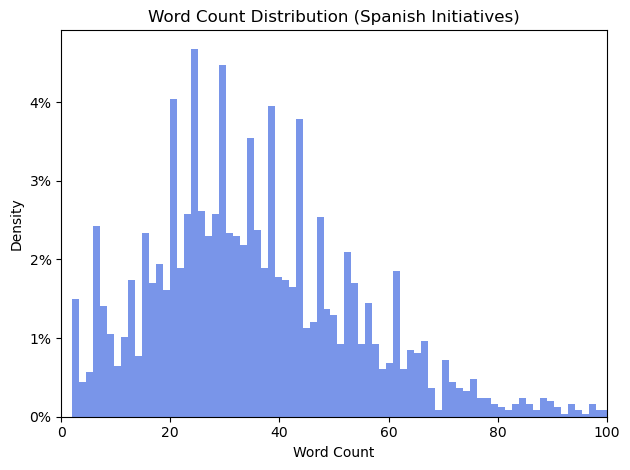

Min: 2
Max: 130
Mean: 35.983467741935485
Initiatives with < 3 words:
 ['Título I' 'Título II' 'Título III' 'Título V' 'Título VI' 'Título VII'
 'Título VIII' 'Anexos  null']


In [279]:
#################################################
# Counting the words of the initiatives - stats #
#################################################

df = pd.read_csv("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/All_initiatives_2016-2025.csv")

df['word_count'] = df['initiative'].str.split().str.len()

df = df[df['word_count'].notna()]
counts = df['word_count'].astype(int)

fig, ax = plt.subplots()

weights = np.ones_like(counts) / len(counts)

ax.hist(counts, bins=100, weights=weights, color="royalblue", alpha=0.7)

ax.set_xlabel("Word Count")
ax.set_ylabel("Density")
ax.set_title("Word Count Distribution (Spanish Initiatives)")

ax.yaxis.set_major_locator(MultipleLocator(0.01))
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=0))
ax.set_xlim(0, 100)
plt.tight_layout()

plt.savefig("results_latex/word_counts_spanish.png")
plt.show()

print("Min:", counts.min())
print("Max:", counts.max())
print("Mean:", counts.mean())
print("Initiatives with < 3 words:\n", df[df['word_count'] < 3]['initiative'].unique())

Results Party Motions and Votes

Function - Motions

In [89]:
import pandas as pd

def create_motion_proposal_summary2(df_ideology, party_codes):
    
    return pd.DataFrame(motions_summary_data).set_index("Party")

Function - Votes

In [92]:
###########################################################################################################################
# Generating a summary table of vote counts and percentages (for, against, other) for each party or model in the dataset. #
###########################################################################################################################

def create_vote_summary_df(df_ideology, party_cols, header="Party"):
    summary_data = []
    print("Total motions analyzed:", len(df_ideology))

    for col in party_cols:
        counts = df_ideology[col].value_counts().reindex([1.0, -1.0, 0.0], fill_value=0)
        proportions = df_ideology[col].value_counts(normalize=True).reindex([1.0, -1.0, 0.0], fill_value=0)

        summary_data.append({
            header: col,
            "Count of For": int(counts[1.0]),
            "Count of Against": int(counts[-1.0]),
            "Count of Other": int(counts[0.0]),
            "For (%)": f"{proportions[1.0]*100:.1f}",
            "Against (%)": f"{proportions[-1.0]*100:.1f}",
            "Other (%)": f"{proportions[0.0]*100:.1f}"
        })

    summary_df = pd.DataFrame(summary_data)
    return summary_df.set_index(header)

party_cols = ['PSOE', 'PP', 'VOX', 'Ciudadanos', 'CUP', 'ERC', 'Junts', 'EH Bildu', 'PNV', 'Más País']  # or your desired columns
summary_df = create_vote_summary_df(df_ideology, party_cols, header="Party")
print(summary_df)


Total motions analyzed: 2480
            Count of For  Count of Against  Count of Other For (%)  \
Party                                                                
PSOE                1500               879             101    60.5   
PP                  1502               729             249    60.6   
VOX                  854               565             309    49.4   
Ciudadanos          1318               498             220    64.7   
CUP                 1241               650             117    61.8   
ERC                  861               531             336    49.8   
Junts                703               326             233    55.7   
EH Bildu             797               488             423    46.7   
PNV                 1300               776             404    52.4   
Más País            1546               628             306    62.3   

           Against (%) Other (%)  
Party                             
PSOE              35.4       4.1  
PP                29.4   

Initiatives

In [95]:
##################################################################################################
# Generating a summary DataFrame showing the proportion of motions proposed by each party across #
# the full period and three custom time periods (2016–2019, 2019–2023, 2023–2025).               #
##################################################################################################

def get_df_initiative_summary_all(df_initiatives, party_codes):
    df_initiatives = df_initiatives.copy()
    df_initiatives["year"] = pd.to_datetime(df_initiatives["date"], dayfirst=True).dt.year
    df_summary_all = create_motion_proposal_summary2(df_initiatives, party_codes)

    periods = {
        "2016–2019": list(range(2016, 2020)),
        "2019–2023": list(range(2019, 2024)),
        "2023–2025": list(range(2023, 2026)),
    }
    
    summaries = {}
    for label, years in periods.items():
        mask = df_initiatives["year"].isin(years)
        summaries[label] = create_motion_proposal_summary2(df_initiatives[mask].copy(), party_codes)

    df_summary_all.rename(columns={"Motions (%)": "All"}, inplace=True)
    for label, df in summaries.items():
        df.rename(columns={"Motions (%)": label}, inplace=True)

    df_combined = pd.concat(
        [df_summary_all] + [summaries[label][label] for label in periods],
        axis=1,
        join="inner"
    )

    return df_combined

In [97]:
#############################################
# Extracting categories and sub-categories  #
#############################################

df = pd.read_csv("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/all_initiatives_with_ALL_party_&_llm_votes.csv")

grouped = df.groupby(['documentcategory', 'subcategory']).size().reset_index(name='count')

grouped = grouped.sort_values(by='count', ascending=False).reset_index(drop=True)

print(grouped)

grouped.to_csv("category_subcategory_counts.csv", index=False)

# To LaTeX for academic formatting
# with open("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/results_latex/category_table.tex", "w") as f:
#     f.write(grouped.to_latex(index=False, caption="Document Categories and Subcategories", label="tab:categories"))

import pandas as pd

df = pd.read_csv("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/All_initiatives_2016-2025.csv")

# Rename columns if needed (uncomment below if needed)
# df.columns = [col.strip().lower().replace(' ', '_') for col in df.columns]

grouped = (
    df.groupby(['documentcategory', 'subcategory'])
    .size()
    .reset_index(name='count')
    .sort_values(by='count', ascending=False)
)

latex_doc_subcat = grouped.to_latex(
    index=False,
    header=["Document Category", "Subcategory", "Count"],
    caption="Document Categories and Subcategories",
    label="tab:document_categories",
    longtable=False
)

category_counts = (
    df['documentcategory']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'Category', 'documentcategory': 'Number of samples'})
)

latex_cat = category_counts.to_latex(
    index=False,
    caption="Political Categories",
    label="tab:political_categories"
)

with open("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/results_latex/document_categories_subcategories.tex", "w") as f:
    f.write(latex_doc_subcat)

with open("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/results_latex/political_categories.tex", "w") as f:
    f.write(latex_cat)


                                     documentcategory  \
0                                 Función legislativa   
1                     Función de orientación política   
2                     Función de orientación política   
3                           Convenios Internacionales   
4               Comisiones, subcomisiones y ponencias   
5                                 Función legislativa   
6                                 Función legislativa   
7                             Reglamento del Congreso   
8               Comisiones, subcomisiones y ponencias   
9                                 Función legislativa   
10    Relaciones con órganos e instituciones públicas   
11  Actos en relación con los estados de alarma, e...   
12              Comisiones, subcomisiones y ponencias   
13    Relaciones con órganos e instituciones públicas   
14                            Reforma Constitucional.   
15                            Reforma Constitucional.   
16                             

Initiative Stats

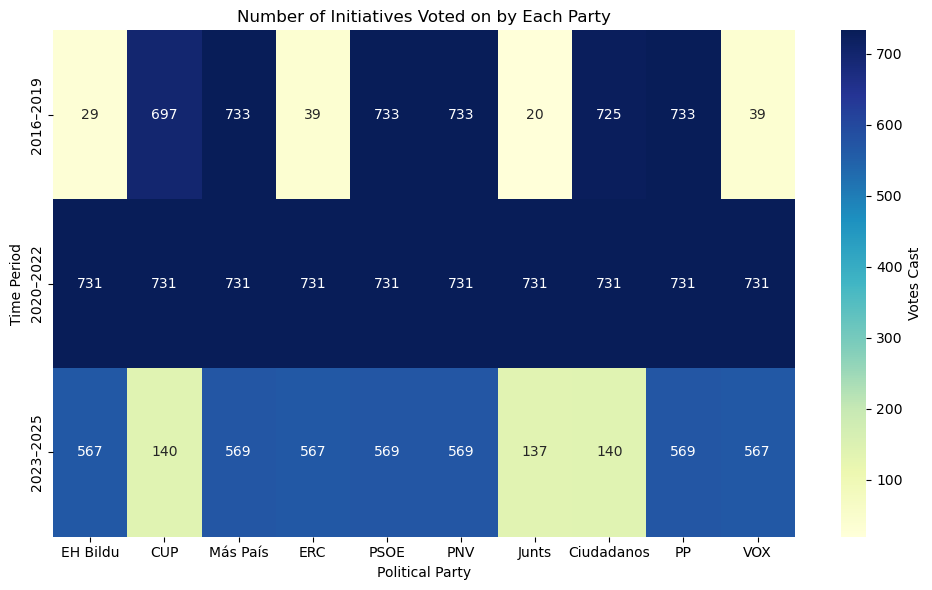

In [281]:
##################################################################################################
# Initiative voting data, extracts the year from dates, counts how many initiatives each Spanish #
# party voted on during defined time periods, and visualizes the results in a heatmap.           #
##################################################################################################

df = pd.read_csv("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/All_initiatives_2016-2025.csv")

df["date"] = pd.to_datetime(df["date"], errors="coerce", dayfirst=True)
df["year"] = df["date"].dt.year

party_cols = ['EH Bildu', 'CUP', 'Más País', 'ERC', 'PSOE', 'PNV', 'Junts', 'Ciudadanos', 'PP', 'VOX']

periods = {
    "2016–2019": list(range(2016, 2019)),
    "2020–2022": list(range(2020, 2022)),
    "2023–2025": list(range(2023, 2026))
}

summary = pd.DataFrame(index=party_cols)

for label, years in periods.items():
    mask = df["year"].isin(years)
    df_period = df.loc[mask, party_cols]

    counts = df_period.notna().sum()
    summary[label] = counts

plt.figure(figsize=(10, 6))
sns.heatmap(summary.T, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={"label": "Votes Cast"})
plt.title("Number of Initiatives Voted on by Each Party")
plt.xlabel("Political Party")
plt.ylabel("Time Period")
plt.tight_layout()
plt.show()

Parties votes

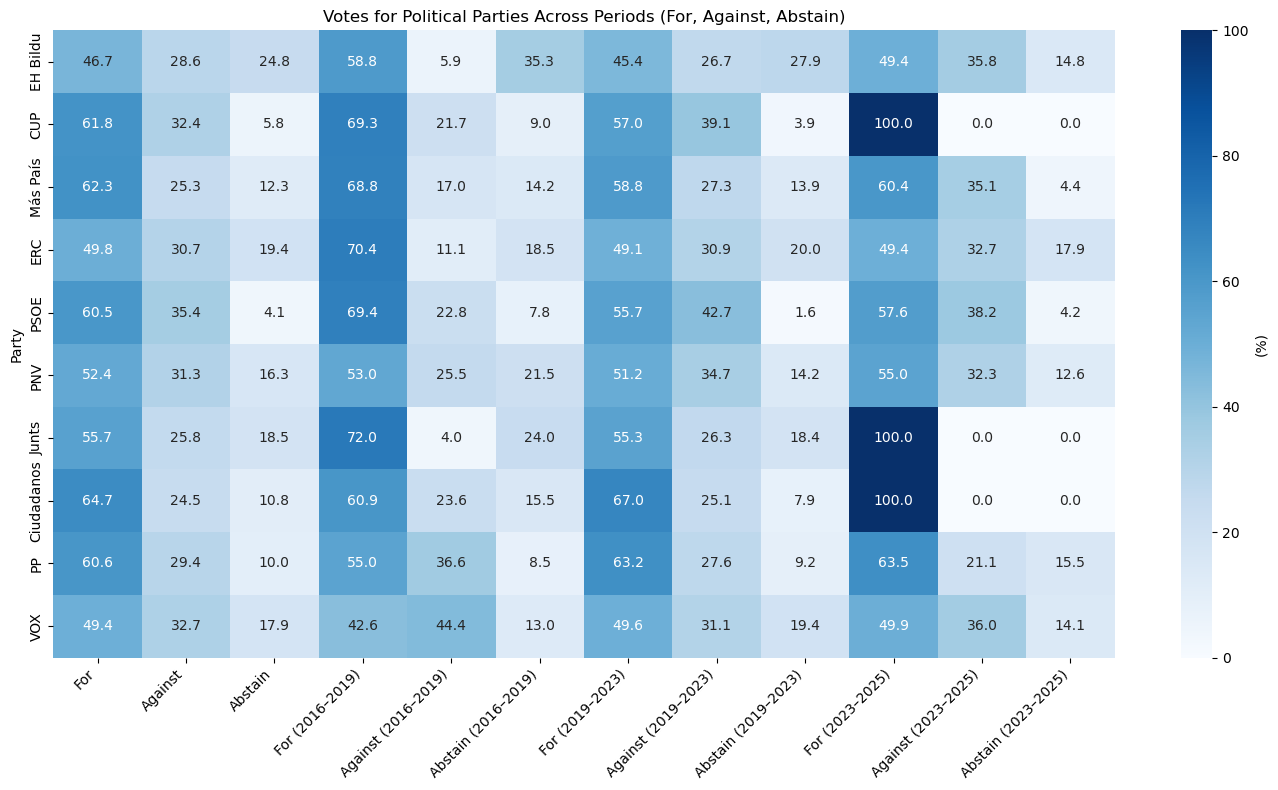

In [103]:
###############################################################################################
# Initiative voting data, assigns each vote to a parliamentary period,                        #
# computes the percentage of "For", "Against", and "Abstain" votes per party for each period  #
###############################################################################################

df = pd.read_csv("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/All_initiatives_2016-2025.csv")

df["date"] = pd.to_datetime(df["date"], dayfirst=True)

periods = {
    "2016–2019": (pd.Timestamp("2016-01-01"), pd.Timestamp("2019-12-31")),
    "2019–2023": (pd.Timestamp("2020-01-01"), pd.Timestamp("2023-06-30")),
    "2023–2025": (pd.Timestamp("2023-07-01"), pd.Timestamp("2025-12-31")),
}

def assign_period(date):
    for label, (start, end) in periods.items():
        if start <= date <= end:
            return label
    return None

df["period"] = df["date"].apply(assign_period)

party_columns = ['EH Bildu', 'CUP', 'Más País', 'ERC', 'PSOE', 'PNV', 'Junts', 'Ciudadanos', 'PP', 'VOX']


def create_vote_summary(df_slice):
    summary = {}
    for party in party_columns:
        total = df_slice[party].notna().sum()
        if total == 0:
            summary[party] = {"For": 0, "Against": 0, "Abstain": 0}
            continue
        votes_for = (df_slice[party] == 1).sum() / total * 100
        votes_against = (df_slice[party] == -1).sum() / total * 100
        votes_abstain = (df_slice[party] == 0).sum() / total * 100
        summary[party] = {
            "For": votes_for,
            "Against": votes_against,
            "Abstain": votes_abstain
        }
    return pd.DataFrame(summary).T

df_vote_summary_all = pd.DataFrame()

total_summary = create_vote_summary(df)
total_summary.columns = [f"{col}" for col in total_summary.columns]
df_vote_summary_all = total_summary.copy()

for label in periods:
    summary = create_vote_summary(df[df["period"] == label])
    summary.columns = [f"{col} ({label})" for col in summary.columns]
    df_vote_summary_all = pd.concat([df_vote_summary_all, summary], axis=1)

df_vote_summary_all = df_vote_summary_all.loc[party_columns]

plt.figure(figsize=(14, 8))
sns.heatmap(df_vote_summary_all, annot=True, fmt=".1f", cmap="Blues", cbar_kws={"label": "(%)"})
plt.title("Votes for Political Parties Across Periods (For, Against, Abstain)")
plt.ylabel("Party")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

Agreement amongst parties

Mean off-diagonal similarity: 53.5%


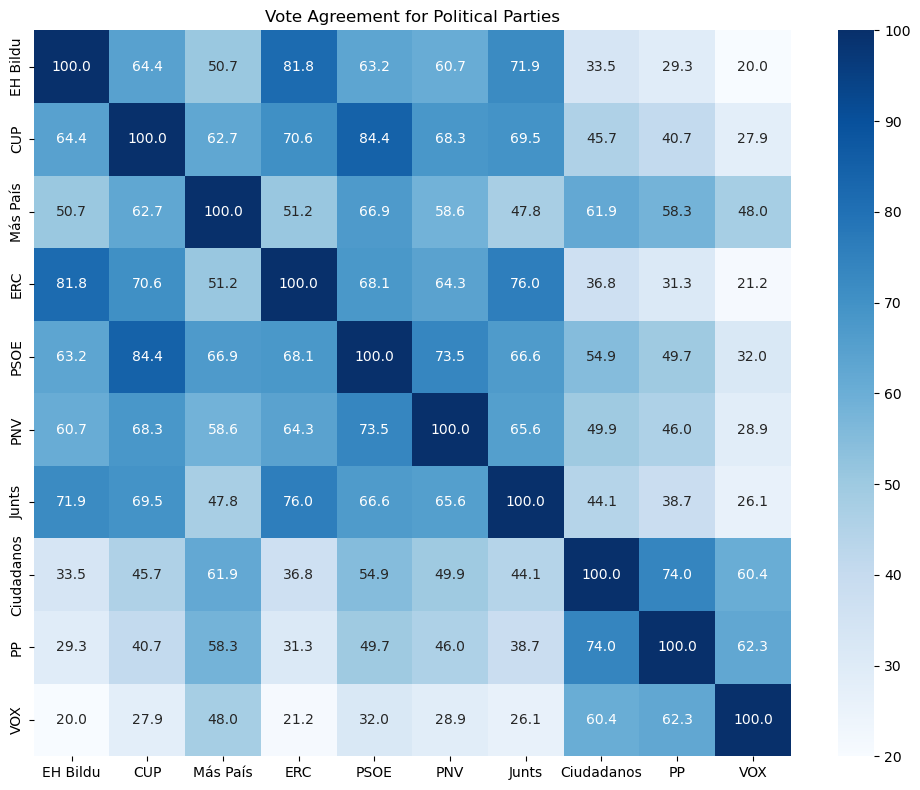

In [106]:
##################################################################################################
# Calculates how often each pair of 10 political parties voted the same on shared initiatives,   #
# computing the average inter-party agreement, and visualizes the agreement matrix as a heatmap. #
##################################################################################################

df = pd.read_csv("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/All_initiatives_2016-2025.csv")
df["date"] = pd.to_datetime(df["date"], dayfirst=True)

party_codes = ['EH Bildu', 'CUP', 'Más País', 'ERC', 'PSOE', 'PNV', 'Junts', 'Ciudadanos', 'PP', 'VOX']
party_codes_left_right = ['EH Bildu', 'CUP', 'Más País', 'ERC', 'PSOE', 'PNV', 'Junts', 'Ciudadanos', 'PP', 'VOX']

df_agreement_parties = pd.DataFrame(index=party_codes, columns=party_codes, dtype=float)

for p1 in party_codes:
    for p2 in party_codes:
        mask = df[p1].notna() & df[p2].notna()
        total_shared = mask.sum()
        
        if total_shared == 0:
            df_agreement_parties.loc[p1, p2] = np.nan
            continue

        if p1 == p2:
            df_agreement_parties.loc[p1, p2] = 100.0
        else:
            same_votes = (df.loc[mask, p1] == df.loc[mask, p2]).sum()
            df_agreement_parties.loc[p1, p2] = round(100 * same_votes / total_shared, 1)

mask = ~np.eye(len(party_codes), dtype=bool)

mean_similarity = (
    df_agreement_parties
    .where(mask)
    .stack()
    .mean()
)

print(f"Mean off-diagonal similarity: {mean_similarity:.1f}%")

def heat_plot(df, title, xlabels, ylabels, filename):
    plt.figure(figsize=(10, 8))
    sns.heatmap(df, annot=True, fmt=".1f", cmap="Blues", xticklabels=xlabels, yticklabels=ylabels)
    plt.title(title)
    plt.tight_layout()

heat_plot(
    df_agreement_parties[party_codes_left_right].T,
    "Vote Agreement for Political Parties",
    party_codes_left_right,
    party_codes_left_right,
    "vote_agreement_parties"
)

plt.savefig("results_latex/vote_agreement_parties.png")
plt.show()

LLM Votes

In [109]:
################################################################################################
# Calculating and summarizes the percentage distribution of vote types (for, against, abstain) #
# for each LLM by reading their respective voting result files.                                #
################################################################################################

files = [
    "Second_Experiments_Results/gemma2_9b_results_ideology_ES_prompt=1.csv",
    "Second_Experiments_Results/aguila7b_results_ideology_ES_prompt=1.csv",
    "Second_Experiments_Results/deepseek_7b_results_ideology_ES_prompt=1.csv",
    "Second_Experiments_Results/falcon3_7b_results_ideology_ES_prompt=1.csv",
    "Second_Experiments_Results/mistral_7b_results_ideology_ES_prompt=1.csv",
    "Second_Experiments_results/llama_2_7b_results_ideology_ES_prompt=1.csv",
    "Second_Experiments_Results/llama3_8b_results_ideology_ES_prompt=1.csv"
]

cols = [
    'gemma2_9b_vote',
    'aguila7b_vote',
    'deepseek_7b_vote',
    'falcon3_7b_vote',
    'mistral_7b_vote',
    'llama_2_7b_vote',
    'llama3_8b_vote'
]

pct_dict = {}

for path, col in zip(files, cols):
    df = pd.read_csv(path)

    df[col] = pd.to_numeric(df[col], errors='coerce')

    pct = (
        df[col]
        .value_counts(normalize=True)
        .mul(100)
        .round(1)
    )
    model = col.replace('_vote', '')
    pct_dict[model] = pct

pct_df = pd.DataFrame(pct_dict).fillna(0).sort_index()

print(pct_df)

    gemma2_9b  aguila7b  deepseek_7b  falcon3_7b  mistral_7b  llama_2_7b  \
-1        0.0      24.6         16.2        25.7         0.0         5.3   
 0       97.7       3.9         13.8        63.1         0.6        19.2   
 1        2.3      71.5         70.0        11.2        99.4        75.5   

    llama3_8b  
-1        0.1  
 0        6.4  
 1       93.5  


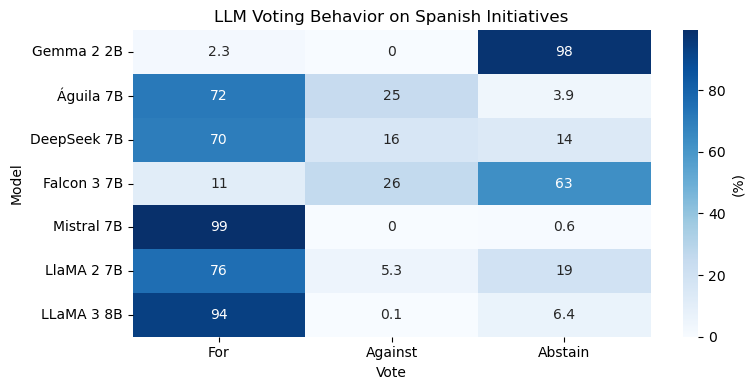

In [111]:
############################################################################################
# Spanish LLM voting data, calculates the percentage of vote types (For, Against, Abstain) #
# per model, and visualizes the results in a heatmap.                                      #
############################################################################################

df = pd.read_csv("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/all_initiatives_with_ALL_party_&_llm_votes.csv")

model_names = ['gemma2_9b', 'aguila7b', 'deepseek_7b', 'falcon3_7b', 'mistral_7b', 'llama_2_7b', 'llama3_8b']
model_names_short = ['Gemma 2 2B', 'Águila 7B', 'DeepSeek 7B', 'Falcon 3 7B', 'Mistral 7B', 'LlaMA 2 7B', 'LLaMA 3 8B']
model_rename_dict = dict(zip(model_names, model_names_short))

def create_vote_summary_df(df, vote_cols, label):
    summary = []
    for col in vote_cols:
        counts = df[col].value_counts(normalize=True).round(3) * 100
        for_ = counts.get(1, 0)
        against = counts.get(-1, 0)
        abstain = counts.get(0, 0)
        summary.append([col, for_, against, abstain])
    summary_df = pd.DataFrame(summary, columns=[label, "For", "Against", "Abstain"])
    return summary_df

summary_df_models = create_vote_summary_df(df, model_names, "LLMs")

summary_df_models["LLMs"] = summary_df_models["LLMs"].map(model_rename_dict)

summary_df_models.set_index("LLMs", inplace=True)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.heatmap(summary_df_models[["For", "Against", "Abstain"]],
            annot=True, cmap="Blues", cbar_kws={"label": "(%)"})
plt.title("LLM Voting Behavior on Spanish Initiatives")
plt.xlabel("Vote")
plt.ylabel("Model")
plt.tight_layout()

# plt.savefig("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/results_latex/models_votes.png", dpi=600, bbox_inches='tight')
plt.show()


Ideology

In [269]:
############# 
# plotting  #
#############

def plot_landscape2(df, title, models, exp, party_codes, colors_models, colors_parties, exp_var, x_pts=None, y_pts=None, signs=[1, 1], pca_model=None, show=True):
    pca_df, pca_model = do_PCA(df, models, party_codes, pca_model)
    # DO plotting
    make_landscape_plot(pca_df, title, models, exp, party_codes, colors_models, colors_parties, exp_var, x_pts, y_pts, signs, show)
    return pca_df, pca_model

def do_PCA(df, models, party_codes, pca_model=None, n_components=2):
    
    columns = party_codes+models
    
    df[columns] = df[columns].fillna(0)
    df[columns] = df[columns].apply(pd.to_numeric)

    df_transposed = df[columns].transpose()
    if pca_model == None:
        pca_model = PCA(n_components=n_components)
        pca_result = pca_model.fit_transform(df_transposed)
    else:
        pca_result = pca_model.transform(df_transposed)
        
    print(len(pca_model.mean_))
    pca_df = pd.DataFrame(data=pca_result, columns=[f'PCA{i+1}' for i in range(pca_result.shape[1])], index=df_transposed.index)
    print(pca_df)
    return pca_df, pca_model

def make_landscape_plot(pca_df, title, models, exp, party_codes, colors_models, colors_parties, exp_var, x_pts=None, y_pts=None, signs=[1, 1], show=True, xlim=None, ylim=None):
    """
    if exp == "ES":
        colors_parties = [
            "#fdbb84",  # Ciudadanos
            "#31a354",  # Más País
            "#3182bd",  # PNV
            "#de2d26",  # PP
            "#756bb1",  # PSOE
            "#e6550d",  # CUP
            "#636363",  # ERC
            "#bdbdbd",  # VOX
            "#6baed6",  # EH Bildu
            "#9ecae1"   # Junts
        ]
    else:
        # fallback or other country setup (keep if needed)
        colors_parties = ['#D91A39','#3C79C1','#0A8E3E','#18295E','#FC9A2B','#85C046','#B21D62','#064B2F','#701C44','#F75822']
    """
    print(colors_parties)
    print(colors_models)
    colors = colors_parties + colors_models
    
    plt.figure(figsize=(10, 10))  # wider and slightly shorter

    df_plot = pca_df.copy()
    
    df_plot.iloc[:, 0] = signs[0] * df_plot.iloc[:, 0] 
    df_plot.iloc[:, 1] = signs[1] * df_plot.iloc[:, 1] 
    
    texts = []
    pca_cols = df_plot.columns
    print(pca_cols)
    for idx, col in enumerate(df_plot.index):
        try:
            if df_plot.index[idx] in ['Abstain', 'Yes', 'No', 'Ran', 'Abstain/Yes/No']:
                marker_style = '^'
            elif idx >= len(df_plot.index) - len(models):
                marker_style = '*'
            else:
                marker_style = 'o'

            plt.scatter(df_plot.loc[col, pca_cols[0]], df_plot.loc[col, pca_cols[1]], 
                        label=col, s=150, color=colors[idx % len(colors)], marker=marker_style)
            
            if col in ['Yes', 'No', 'Ran', 'Abstain/Yes/No']:
                x_offset, y_offset = 0.02, 1.02 
            else:
                x_offset, y_offset = -0.08, 1.1
                
            texts.append(plt.text(df_plot.loc[col, pca_cols[0]] + x_offset, df_plot.loc[col, pca_cols[1]] + y_offset, col, fontsize=8, fontweight='medium'))
        except Exception as e:
            print(f"Error plotting index {idx}: {e}")

    if xlim == None:        
        adjust_text(texts, 
                    force_text=(8, 8),#(4, 3), 
                    expand_text=(2, 2),#(0, 0), 
                    only_move={'text': 'xy'},
                    autoalign='xy'
                   )
        
    plt.xlabel(pca_cols[0], fontsize=18)
    plt.ylabel(pca_cols[1], fontsize=18)
    
    #plt.title(title)
    plt.grid(True, linestyle=':', linewidth=1, alpha=0.7)

    
    if x_pts != None:
        for i in range(len(x_pts)): 
            plt.plot([-60, 80], [-70, 80], color='black', linestyle='--', label='Extra line')
            plt.plot([-60, 80], [70, -70], color='black', linestyle='--', label='Extra line')

    if xlim != None:
        plt.xlim(xlim)
    if ylim != None:
        plt.ylim(ylim)
    
    x = df_plot.iloc[:, 0]
    y = df_plot.iloc[:, 1]
    
    x_pad = (x.max() - x.min()) * 0.15  # from 0.15 to 0.25
    y_pad = (y.max() - y.min()) * 0.15
    
    plt.xlim(x.min() - x_pad, x.max() + x_pad)
    plt.ylim(y.min() - y_pad, y.max() + y_pad)
    
    if show:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.savefig("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/results_latex/political_landscape_{exp_var}.png", dpi=600, bbox_inches='tight')
        plt.show()
    plt.close()

PCA POLITICAL LANDSCAPE

Fit on parties, transform on models¶

2480
                  PCA1       PCA2
EH Bildu    -10.740305  19.163326
CUP          -4.609307  24.835682
Más País      4.345651   6.766068
ERC         -10.417258  21.016291
PSOE         -4.157178  28.736914
PNV          -5.565417  23.937942
Junts        -8.348532  11.553169
Ciudadanos    4.517914 -15.822083
PP            4.654346 -23.270696
VOX          -5.454538 -29.312662
Gemma 2 2B  -11.875355  -6.883079
Águila 7B    14.135209  -4.417735
DeepSeek 7B  16.978834  -6.883915
Falcon 3 7B -22.740885  -8.352833
Mistral 7B   35.461041  -1.545237
LlaMA 2 7B   23.906702  -4.586901
LLaMA 3 8B   32.803002  -1.451758
Abstain     -12.956462  -7.425658
Yes          35.698014  -1.744780
Ran         -14.024537 -11.205518
No          -61.610939 -13.106536
['#fdbb84', '#31a354', '#3182bd', '#de2d26', '#756bb1', '#e6550d', '#636363', '#bdbdbd', '#6baed6', '#9ecae1']
['#B5AAC5', '#1E90FF', '#4520AD', '#9342A7', '#BC77B4', '#000080', '#4682B4', '#F8BBD0', '#FFC0CB', '#EC407A', '#C2185B']
Index(['PCA1',

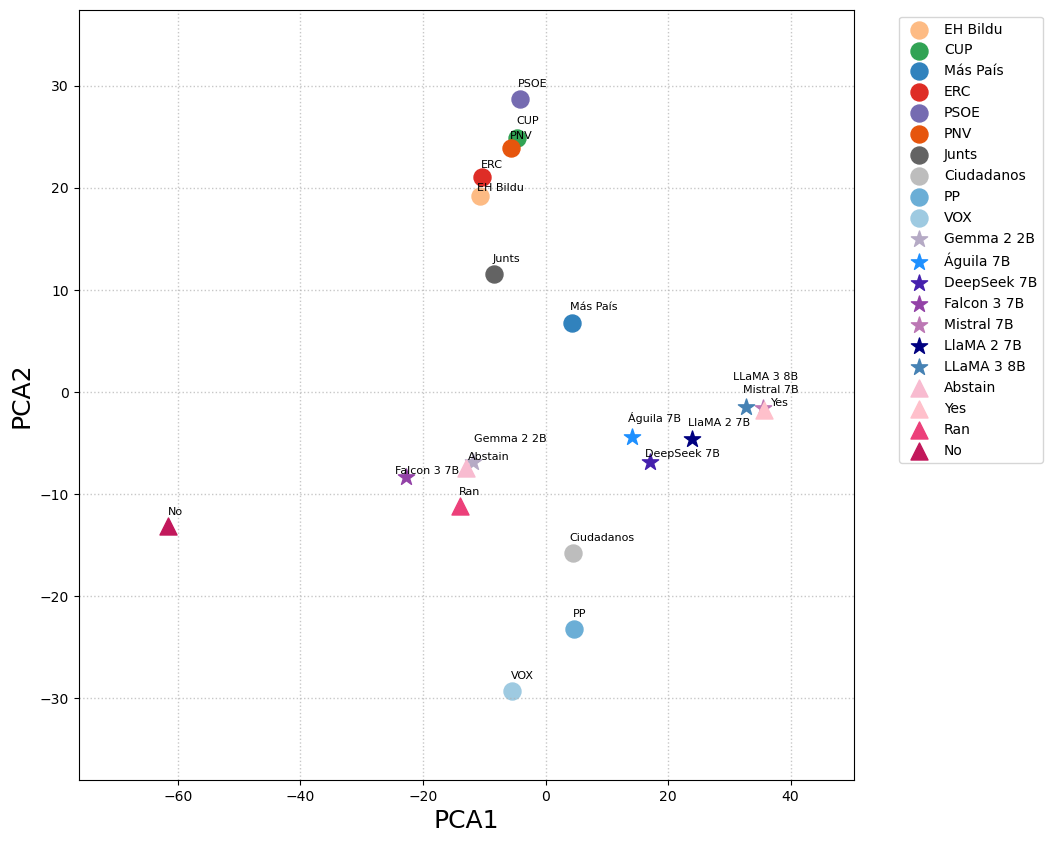

In [273]:
#######################################################################################
# Spanish party and LLM voting data, performs PCA to project them into a 2D political #
# landscape,and visualizes the ideological positions of parties and models.           #
#######################################################################################

df_ideology = pd.read_csv("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/all_initiatives_with_ALL_party_&_llm_votes.csv")

df_ideology['Yes'] = 1
df_ideology['No'] = -1
df_ideology['Abstain'] = 0
df_ideology['Ran'] = np.random.choice([-1, 1, 0], size=len(df_ideology))
men_cols = [ 'Abstain', 'Yes', 'Ran', 'No']

fit_pca_parties = True
party_cols = ['EH Bildu', 'CUP', 'Más País', 'ERC', 'PSOE', 'PNV', 'Junts', 'Ciudadanos', 'PP', 'VOX']
model_names_short_list = ['gemma2_9b', 'aguila7b', 'deepseek_7b', 'falcon3_7b', 'mistral_7b', 'llama_2_7b', 'llama3_8b']
model_names_short      = ['Gemma 2 2B', 'Águila 7B', 'DeepSeek 7B', 'Falcon 3 7B', 'Mistral 7B', 'LlaMA 2 7B', 'LLaMA 3 8B']


#model_names_short_list[:-1] = ['Gemma 2 2B', 'Águila 7B', 'DeepSeek 7B', 'Falcon 3 7B', 'Mistral 7B', 'LlaMA 2 7B', 'LLaMA 3 8B']

colors_parties = [
    "#fdbb84", "#31a354", "#3182bd", "#de2d26", "#756bb1",
    "#e6550d", "#636363", "#bdbdbd", "#6baed6", "#9ecae1"
]

colors_models = [
    '#B5AAC5',  # gemma2_9b
    '#1E90FF',  # aguila7b
    '#4520AD',  # deepseek_7b
    '#9342A7',  # falcon3_7b
    '#BC77B4',  # mistral_7b
    '#000080',  # llama_2_7b
    '#4682B4',  # llama3_8b
    '#F8BBD0',  # Abstain
    '#FFC0CB', # Yes
    '#EC407A', # Ran
    '#C2185B'  # No
]

coords = {
    'EH Bildu': (-10.644448, 19.279549),
    'CUP': (-4.658417, 24.667151),
    'Más País': (4.398206, 6.718022),
    'ERC': (-10.313618, 21.136568),
    'PSOE': (-4.114951, 28.650477),
    'PNV': (-5.561468, 23.820113),
    'Junts': (-8.332401, 11.541916),
    'Ciudadanos': (4.482572, -15.975919),
    'PP': (4.514466, -23.605177),
    'VOX': (-5.456302, -29.333102),
    'gemma2_9b': (-11.813986, -6.782065),
    'aguila7b': (14.127726, -4.447002),
    'deepseek_7b': (17.006515, -6.856800),
    'falcon3_7b': (-22.615206, -8.121261),
    'mistral_7b': (35.512305, -1.514904),
    'llama_2_7b': (23.951993, -4.535610),
    'llama3_8b': (32.863201, -1.412538),
    'Abstain': (-12.921176, -7.361411),
    'Yes': (35.750490, -1.712637),
    'Ran': (-14.582659, -11.145187),
    'No': (-61.592842, -13.010185)
}

df_labels = pd.DataFrame(coords).T
df_labels.columns = ['x', 'y']

offset_x = 1.5
offset_y = 1.5
df_labels['label_x'] = df_labels['x'] + offset_x
df_labels['label_y'] = df_labels['y'] + offset_y

name_map = dict(zip(model_names_short_list, model_names_short))
df_labels.rename(index=name_map, inplace=True)

if fit_pca_parties:
    exp = "ES"
    exp_var = "v1"

df_ideology_short = df_ideology.rename(columns=name_map)

models_short = model_names_short + men_cols

pca_df, pca_model = plot_landscape2(
    df=df_ideology_short,
    title="Political Compass: Spanish Parties + LLMs",
    models=models_short,
    exp=exp,
    party_codes=party_codes,
    colors_models=colors_models,
    colors_parties=colors_parties,
    exp_var=exp_var,
    signs=[1, 1]
)

Centered

2480
                 PCA1       PCA2
EH Bildu    17.776533  15.322825
CUP         19.094942  -5.238034
Más País    -4.904237 -18.524463
ERC         19.105112  14.411293
PSOE        18.589019 -18.606670
PNV         15.537589 -10.351076
Junts        9.784981  16.870964
Ciudadanos -26.536801   0.265265
PP         -35.262243  -2.046581
VOX        -33.184896   7.896477
2480
                 PCA1       PCA2
Gemma 2 2B  -6.636644  10.647001
Águila 7B   -4.469151  10.231212
DeepSeek 7B -7.521739  10.700759
Falcon 3 7B -5.644417  13.676353
Mistral 7B  -6.879588  10.762783
LlaMA 2 7B  -6.582213  11.625217
LLaMA 3 8B  -7.142550   9.694483
Abstain     -7.100342  10.856556
Yes         -7.100342  10.856556
Ran         -7.783410  11.169216
No          -7.100342  10.856556
['#fdbb84', '#31a354', '#3182bd', '#de2d26', '#756bb1', '#e6550d', '#636363', '#bdbdbd', '#6baed6', '#9ecae1']
['#B5AAC5', '#1E90FF', '#4520AD', '#9342A7', '#BC77B4', '#000080', '#4682B4', '#F8BBD0', '#FFC0CB', '#EC407A', '#C2185B'

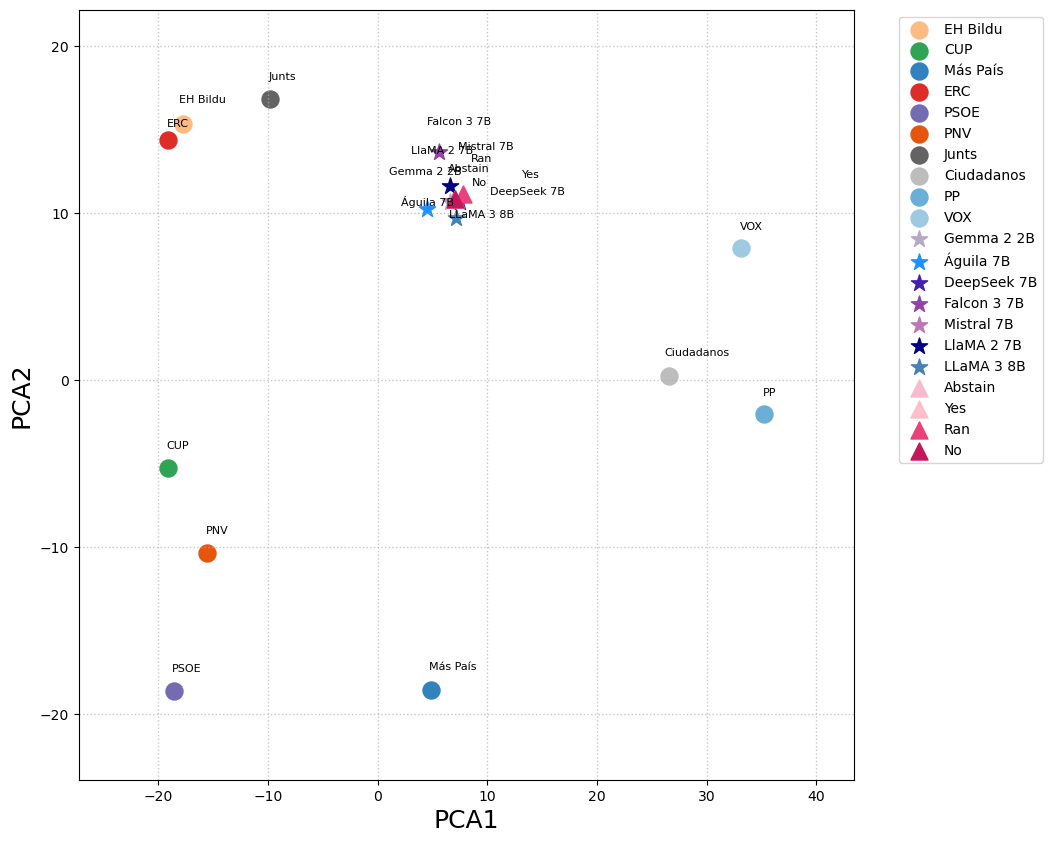

In [283]:
#######################################################################################
# Spanish party and LLM voting data, performs PCA to project them into a 2D political #
# landscape, and visualizes the ideological positions of parties and models.          #
#######################################################################################


df_ideology = pd.read_csv(
    "/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/all_initiatives_with_ALL_party_&_llm_votes.csv"
)

party_codes = ['EH Bildu', 'CUP', 'Más País', 'ERC', 'PSOE', 'PNV', 'Junts', 'Ciudadanos', 'PP', 'VOX']
model_names_short_list = ['gemma2_9b', 'aguila7b', 'deepseek_7b', 'falcon3_7b', 'mistral_7b', 'llama_2_7b', 'llama3_8b']
model_names_short = ['Gemma 2 2B', 'Águila 7B', 'DeepSeek 7B', 'Falcon 3 7B', 'Mistral 7B', 'LlaMA 2 7B', 'LLaMA 3 8B']
men_cols = ['Abstain', 'Yes', 'Ran', 'No']

fit_pca_parties = True
undersample = False
exp_var = "ES"

name_map = dict(zip(model_names_short_list, model_names_short))

df_ideology['Abstain'] = 0
df_ideology['Yes'] = 1
df_ideology['No'] = -1
df_ideology['Ran'] = np.random.choice([-1, 1], size=len(df_ideology))

colors_models = [
    '#B5AAC5', 
    '#1E90FF', 
    '#4520AD', 
    '#9342A7',
    '#BC77B4', 
    '#000080',
    '#4682B4' 
]
colors_men = ['#F8BBD0', '#FFC0CB', '#EC407A', '#C2185B']  # Abstain, Yes, Ran, No
colors_parties = [
    "#fdbb84", "#31a354", "#3182bd", "#de2d26", "#756bb1",
    "#e6550d", "#636363", "#bdbdbd", "#6baed6", "#9ecae1"
]

all_cols = party_codes + model_names_short_list + men_cols
df_centered = df_ideology[all_cols].copy()
df_centered = df_centered.sub(df_centered.mean(axis=0), axis=1)

df_centered.rename(columns=name_map, inplace=True)
models_short = model_names_short + men_cols

if fit_pca_parties:
    signs = [-1, 1]
    zoom_lims = [[-6, 6], [-11, 1]]
    if undersample:
        signs = [1, 1]
        zoom_lims = [[-6, 6], [-10, 2]]

    pca_parties_df_cent, pca_model_cent = do_PCA(df_centered, [], party_codes)

    pca_models_df_cent, _ = do_PCA(df_centered, models_short, [], pca_model=pca_model_cent)

    pca_df_cent = pd.concat([pca_parties_df_cent, pca_models_df_cent], ignore_index=False)

    make_landscape_plot(
        pca_df_cent,
        title='political_compass_parties_models_centered',
        models=models_short,
        exp="ES",
        party_codes=party_codes,
        colors_models=colors_models + colors_men,
        colors_parties=colors_parties,
        exp_var=exp_var,
        signs=signs
    )

2480
                 PCA1       PCA2
EH Bildu    17.776533  15.322825
CUP         19.094942  -5.238034
Más País    -4.904237 -18.524463
ERC         19.105112  14.411293
PSOE        18.589019 -18.606670
PNV         15.537589 -10.351076
Junts        9.784981  16.870964
Ciudadanos -26.536801   0.265265
PP         -35.262243  -2.046581
VOX        -33.184896   7.896477
2480
                    PCA1       PCA2
Gemma 2 2B     -6.636644  10.647001
Águila 7B      -4.469151  10.231212
DeepSeek 7B    -7.521739  10.700759
Falcon 3 7B    -5.644417  13.676353
Mistral 7B     -6.879588  10.762783
LlaMA 2 7B     -6.582213  11.625217
LLaMA 3 8B     -7.142550   9.694483
Ran            -7.783410  11.169216
Abstain/Yes/No -7.100342  10.856556
[]
['#B5AAC5', '#1E90FF', '#4520AD', '#9342A7', '#BC77B4', '#000080', '#4682B4', '#FFC0CB', '#F8BBD0']
Index(['PCA1', 'PCA2'], dtype='object')


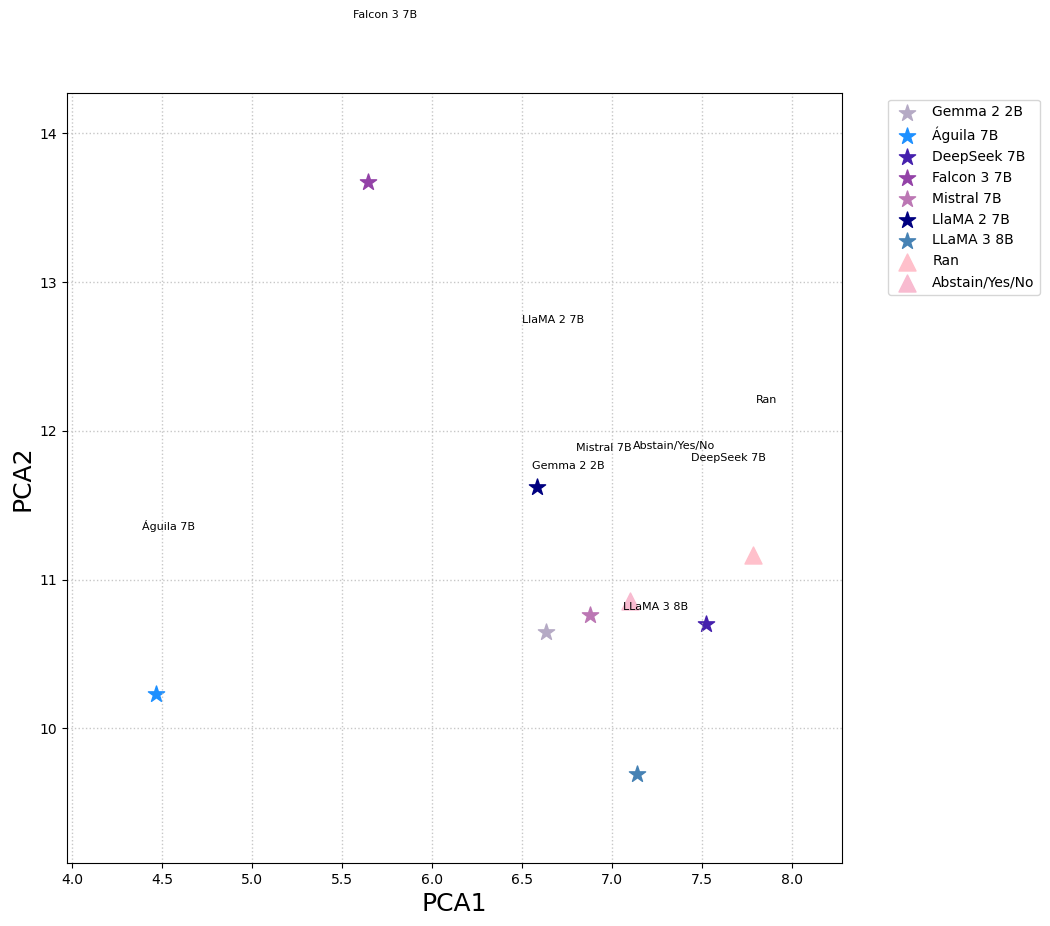

In [285]:
df_centered = df_ideology[party_codes + model_names_short_list + men_cols].copy()
df_centered = df_centered.sub(df_centered.mean(axis=0), axis=1)
df_centered['Abstain/Yes/No'] = (df_centered['Yes'] + df_centered['No'] + df_centered['Abstain']) / 3

name_map = dict(zip(model_names_short_list, model_names_short))
df_centered.rename(columns=name_map, inplace=True)

models_short = model_names_short + ['Ran', 'Abstain/Yes/No']

if fit_pca_parties:
    pca_parties_df_cent, pca_model_cent = do_PCA(df_centered, [], party_codes)

    pca_models_df_cent, _ = do_PCA(
        df_centered,
        models_short,
        [],
        pca_model=pca_model_cent
    )

    pca_df_cent = pd.concat([pca_parties_df_cent, pca_models_df_cent], ignore_index=False)

zoom_models = models_short
zoom_colors = colors_models[:7] + [colors_men[1], colors_men[0]]

zoom_df = pca_df_cent.loc[pca_df_cent.index.intersection(zoom_models)].copy()
zoom_df = zoom_df[~zoom_df.index.duplicated(keep='first')]

padding = 1.5
xlim = (zoom_df['PCA1'].min() - padding, zoom_df['PCA1'].max() + padding)
ylim = (zoom_df['PCA2'].min() - padding, zoom_df['PCA2'].max() + padding)

make_landscape_plot(
    zoom_df, 
    title='political_compass_models_zoomed_clean',
    models=zoom_models,                        
    exp="ES",
    party_codes=[],                            
    colors_models=zoom_colors,
    colors_parties=[],                          
    exp_var=exp_var,
    signs=signs,
    xlim=xlim,
    ylim=ylim
)

Certainty

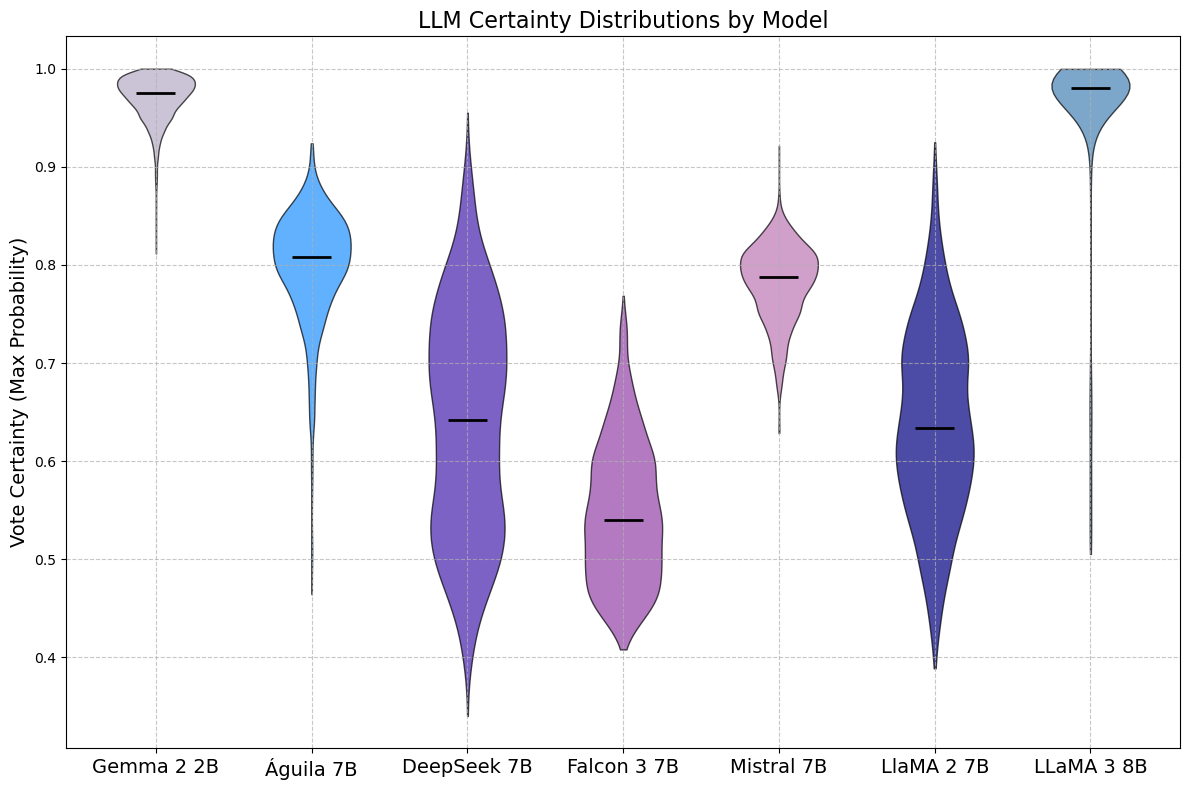

In [287]:
##################################################################################################
# Loading LLM vote probability data, computes each model's certainty (highest class probability  #
# per decision), and generates a violin plot to visualize certainty distributions across models. #
##################################################################################################

model_names = ['gemma2_9b', 'aguila7b', 'deepseek_7b', 'falcon3_7b', 'mistral_7b', 'llama_2_7b', 'llama3_8b']
model_names_short = ['Gemma 2 2B', 'Águila 7B', 'DeepSeek 7B', 'Falcon 3 7B', 'Mistral 7B', 'LlaMA 2 7B', 'LLaMA 3 8B']
model_rename_dict = dict(zip(model_names, model_names_short))

colors_models = [
    '#B5AAC5',
    '#1E90FF',
    '#4520AD',
    '#9342A7',
    '#BC77B4',
    '#000080',
    '#4682B4'
]

folder = "/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/Second_Experiments_Results"
results_latex_folder = "Results/plots"
exp_var = "ES"

certainty_vals = pd.DataFrame()
used_models = []

for model in model_names:
    file_path = f"{folder}/{model}_results_ideology_ES_prompt=1.csv"
    try:
        df = pd.read_csv(file_path)
        for_col = f"{model}_for_prob"
        against_col = f"{model}_against_prob"
        abstain_col = f"{model}_abstain_prob"
        
        if all(col in df.columns for col in [for_col, against_col, abstain_col]):
            certainty = df[[for_col, against_col, abstain_col]].max(axis=1)
            certainty_vals[model] = certainty
            used_models.append(model)
        else:
            print(f"Skipped {model}: missing one or more probability columns.")
    except Exception as e:
        print(f"Could not read {model} file: {e}")

certainty_vals = certainty_vals.dropna(how='all')

used_models_short = [model_rename_dict[m] for m in used_models]
colors_used = colors_models[:len(used_models)]

certainty_vals.rename(columns=model_rename_dict, inplace=True)

violinplot(certainty_vals, used_models_short, colors_used, exp_var, "violin_certainty")

In [151]:
##################################################################################################
# summary statistics of model vote certainty: the proportion of predictions above 0.95, followed #
# by the median, mean, minimum, and maximum certainty per model—rounded to two decimals.         #
##################################################################################################

print((certainty_vals.gt(0.95).mean(axis=0)).round(2))
print("Median")
print((certainty_vals.median(axis=0)).round(2))
print((certainty_vals.mean(axis=0)).round(2))
print((certainty_vals.min(axis=0)).round(2))
print((certainty_vals.max(axis=0)).round(2))

gemma2_9b      0.83
aguila7b       0.00
deepseek_7b    0.00
falcon3_7b     0.00
mistral_7b     0.00
llama_2_7b     0.00
llama3_8b      0.87
dtype: float64
Median
gemma2_9b      0.98
aguila7b       0.81
deepseek_7b    0.64
falcon3_7b     0.54
mistral_7b     0.79
llama_2_7b     0.63
llama3_8b      0.98
dtype: float64
gemma2_9b      0.97
aguila7b       0.80
deepseek_7b    0.64
falcon3_7b     0.55
mistral_7b     0.78
llama_2_7b     0.64
llama3_8b      0.95
dtype: float64
gemma2_9b      0.81
aguila7b       0.46
deepseek_7b    0.34
falcon3_7b     0.41
mistral_7b     0.63
llama_2_7b     0.39
llama3_8b      0.51
dtype: float64
gemma2_9b      1.00
aguila7b       0.92
deepseek_7b    0.96
falcon3_7b     0.77
mistral_7b     0.92
llama_2_7b     0.93
llama3_8b      1.00
dtype: float64


Agreement LLMs and Parties

In [204]:
#########################################################################################################
# Computing and formatting the agreement (as a percentage) between each political party and each LLM,   #
# measuring how often their votes match on shared initiatives, and outputs a transposed DataFrame where #
# models are rows and parties are columns.                                                              #
#########################################################################################################

model_names      = ['gemma2_9b', 'aguila7b', 'deepseek_7b', 'falcon3_7b', 'mistral_7b', 'llama_2_7b', 'llama3_8b']
model_names_short = ['Gemma 2B', 'Águila 7B', 'DeepSeek 7B', 'Falcon 3 7B', 'Mistral 7B', 'LlaMA 2 7B', 'LLaMA 3 8B']

agreement_df = pd.DataFrame(index=model_names_short, columns=party_codes)

for col in party_codes:
    for model_col in model_names_short_list:
        agreement = np.round((df_ideology[col] == df_ideology[model_col]).mean() * 100, 1)
        agreement_df.loc[col, model_col] = agreement

agreement_df = agreement_df[model_names_short_list]
agreement_df = agreement_df.transpose()
agreement_df = agreement_df[party_codes]

agreement_df

,EH Bildu,CUP,Más País,ERC,PSOE,PNV,Junts,Ciudadanos,PP,VOX
gemma2_9b,17.8,6.2,13.4,14.3,6.0,17.3,10.0,10.1,10.7,12.6
aguila7b,30.0,43.8,51.6,31.8,53.4,48.7,25.8,41.9,51.0,29.0
deepseek_7b,27.4,39.6,51.2,29.3,48.9,45.2,23.8,41.2,49.8,30.6
falcon3_7b,20.1,14.0,22.3,18.8,18.5,24.8,12.8,15.6,18.5,18.1
mistral_7b,32.1,50.0,62.3,34.6,60.5,52.3,28.3,52.9,60.2,34.2
llama_2_7b,30.2,39.4,49.7,31.2,48.0,44.3,25.7,41.0,47.7,27.7
llama3_8b,31.1,47.5,59.8,33.9,58.3,51.2,26.9,51.6,58.7,35.5


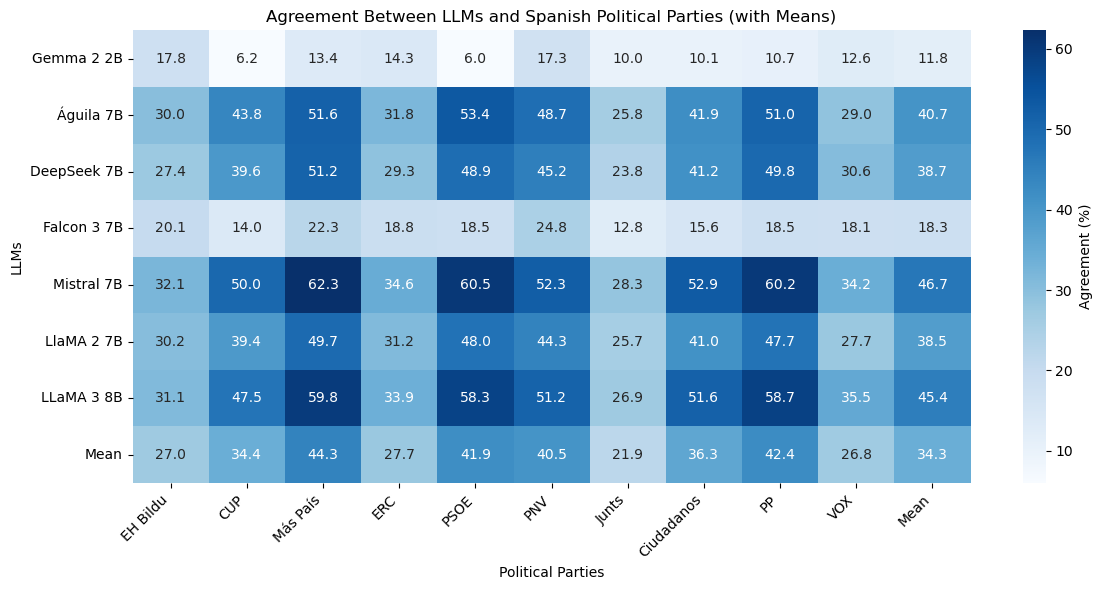

In [239]:
agreement_df['Mean'] = agreement_df.mean(axis=1)
mean_row = agreement_df.mean(axis=0).to_frame().T
mean_row.index = ['Mean']
agreement_with_means = pd.concat([agreement_df, mean_row])

model_names = ['gemma2_9b', 'aguila7b', 'deepseek_7b', 'falcon3_7b', 'mistral_7b', 'llama_2_7b', 'llama3_8b']
model_names_short = ['Gemma 2 2B', 'Águila 7B', 'DeepSeek 7B', 'Falcon 3 7B', 'Mistral 7B', 'LlaMA 2 7B', 'LLaMA 3 8B']
name_map = dict(zip(model_names, model_names_short))

agreement_with_means = agreement_with_means.rename(index=name_map)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.heatmap(
    agreement_with_means.astype(float),
    annot=True,
    fmt=".1f",
    cmap="Blues",
    cbar_kws={"label": "Agreement (%)"},
    xticklabels=agreement_with_means.columns,
    yticklabels=agreement_with_means.index
)

plt.title("Agreement Between LLMs and Spanish Political Parties (with Means)")
plt.xlabel("Political Parties")
plt.ylabel("LLMs")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# plt.savefig("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/results_latex/agreement_LLMs_Parties.png", dpi=600, bbox_inches='tight')

plt.show()

In [218]:
###########################################################################################################
# Computing the 3-class balanced agreement (as a percentage) between each party and each LLM              #
# by comparing only the initiatives on which both have voted, and storing the result in a                 #
# party-by-model DataFrame. This includes agreement on "for", "against", and "abstain" votes equally.     #
###########################################################################################################

party_cols = ['EH Bildu', 'CUP', 'Más País', 'ERC', 'PSOE', 'PNV', 'Junts', 'Ciudadanos', 'PP', 'VOX']
model_names_short_list = ['gemma2_9b', 'aguila7b', 'deepseek_7b', 'falcon3_7b', 'mistral_7b', 'llama_2_7b', 'llama3_8b']
vote_classes = [1, -1, 0]

balanced3_df = pd.DataFrame(index=party_cols, columns=model_names_short_list)

for party_col in party_cols:
    for model_col in model_names_short_list:
        if party_col in df_ideology.columns and model_col in df_ideology.columns:
            valid_mask = df_ideology[party_col].notna() & df_ideology[model_col].notna()
            y_true = df_ideology.loc[valid_mask, party_col]
            y_pred = df_ideology.loc[valid_mask, model_col]

            if len(y_true) >= 10:
                try:
                    class_agreements = []
                    for cls in vote_classes:
                        cls_mask = (y_true == cls)
                        n_cls = cls_mask.sum()
                        if n_cls > 0:
                            n_agree = (y_pred[cls_mask] == y_true[cls_mask]).sum()
                            class_agreements.append(n_agree / n_cls)
                        else:
                            class_agreements.append(np.nan)

                    avg_score = np.nanmean(class_agreements)
                    balanced3_df.loc[party_col, model_col] = round(avg_score * 100, 2)

                except Exception as e:
                    print(f"Error for {party_col} vs {model_col}: {e}")
                    balanced3_df.loc[party_col, model_col] = np.nan
            else:
                balanced3_df.loc[party_col, model_col] = np.nan
        else:
            print(f"Missing column: {party_col} or {model_col}")

balanced3_df = balanced3_df.T
balanced3_df

,EH Bildu,CUP,Más País,ERC,PSOE,PNV,Junts,Ciudadanos,PP,VOX
gemma2_9b,33.64,33.53,32.95,33.24,34.07,33.24,32.99,33.33,32.24,32.62
aguila7b,35.39,34.52,33.58,34.78,33.99,35.39,36.31,31.85,33.4,31.05
deepseek_7b,31.31,32.93,34.85,31.41,33.81,33.92,33.27,33.36,34.26,35.07
falcon3_7b,33.03,29.6,34.24,32.1,35.87,34.58,30.8,32.45,28.54,33.22
mistral_7b,33.41,33.54,33.64,33.32,33.95,33.34,33.52,33.41,33.27,33.24
llama_2_7b,35.5,33.01,32.78,34.94,34.21,33.34,36.79,30.91,30.29,29.31
llama3_8b,33.4,33.0,33.98,33.38,35.26,33.47,32.99,35.42,34.66,37.83


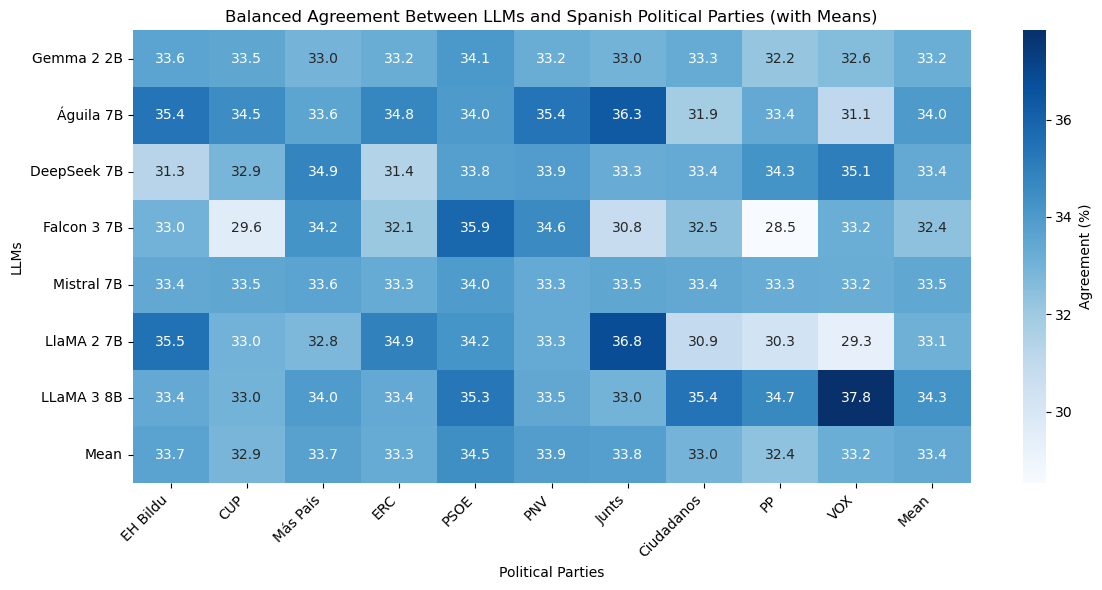

In [247]:
###########################################################################################################
# Computing the 3-class balanced agreement (as a percentage) between each party and each LLM              #
# by comparing only the initiatives on which both have voted, and storing the result in a                 #
# party-by-model DataFrame. This includes agreement on "for", "against", and "abstain" votes equally.     #
###########################################################################################################

party_cols = ['EH Bildu', 'CUP', 'Más País', 'ERC', 'PSOE', 'PNV', 'Junts', 'Ciudadanos', 'PP', 'VOX']
model_names_short_list = ['gemma2_9b', 'aguila7b', 'deepseek_7b', 'falcon3_7b', 'mistral_7b', 'llama_2_7b', 'llama3_8b']
model_names_pretty = ['Gemma 2 2B', 'Águila 7B', 'DeepSeek 7B', 'Falcon 3 7B', 'Mistral 7B', 'LlaMA 2 7B', 'LLaMA 3 8B']
vote_classes = [1, -1, 0]

name_map = dict(zip(model_names_short_list, model_names_pretty))

balanced3_df = pd.DataFrame(index=party_cols, columns=model_names_short_list)

for party_col in party_cols:
    for model_col in model_names_short_list:
        if party_col in df_ideology.columns and model_col in df_ideology.columns:
            valid_mask = df_ideology[party_col].notna() & df_ideology[model_col].notna()
            y_true = df_ideology.loc[valid_mask, party_col]
            y_pred = df_ideology.loc[valid_mask, model_col]

            if len(y_true) >= 10:
                try:
                    class_agreements = []
                    for cls in vote_classes:
                        cls_mask = (y_true == cls)
                        n_cls = cls_mask.sum()
                        if n_cls > 0:
                            n_agree = (y_pred[cls_mask] == y_true[cls_mask]).sum()
                            class_agreements.append(n_agree / n_cls)
                        else:
                            class_agreements.append(np.nan)

                    avg_score = np.nanmean(class_agreements)
                    balanced3_df.loc[party_col, model_col] = round(avg_score * 100, 2)

                except Exception as e:
                    print(f"Error for {party_col} vs {model_col}: {e}")
                    balanced3_df.loc[party_col, model_col] = np.nan
            else:
                balanced3_df.loc[party_col, model_col] = np.nan
        else:
            print(f"Missing column: {party_col} or {model_col}")

balanced3_df = balanced3_df.T.astype(float)

balanced3_df['Mean'] = balanced3_df.mean(axis=1).round(1)

mean_row = balanced3_df.mean(axis=0).to_frame().T
mean_row.index = ['Mean']

balanced3_with_means = pd.concat([balanced3_df, mean_row])

balanced3_with_means = balanced3_with_means.rename(index=name_map)
if 'Mean' in balanced3_with_means.index:
    balanced3_with_means.rename(index={'Mean': 'Mean'}, inplace=True)

plt.figure(figsize=(12, 6))
sns.heatmap(
    balanced3_with_means,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    cbar_kws={"label": "Agreement (%)"},
    xticklabels=balanced3_with_means.columns,
    yticklabels=balanced3_with_means.index
)

plt.title("Balanced Agreement Between LLMs and Spanish Political Parties (with Means)")
plt.xlabel("Political Parties")
plt.ylabel("LLMs")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# plt.savefig("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/results_latex/balanced_agreement_LLMs_Parties.png", dpi=600, bbox_inches='tight')

plt.show()

Heat map - Agreement

             EH Bildu    CUP  Más País    ERC   PSOE    PNV  Junts  \
gemma2_9b       33.64  33.53     32.95  33.24  34.07  33.24  32.99   
aguila7b        35.39  34.52     33.58  34.78  33.99  35.39  36.31   
deepseek_7b     31.31  32.93     34.85  31.41  33.81  33.92  33.27   
falcon3_7b      33.03  29.60     34.24  32.10  35.87  34.58  30.80   
mistral_7b      33.41  33.54     33.64  33.32  33.95  33.34  33.52   
llama_2_7b      35.50  33.01     32.78  34.94  34.21  33.34  36.79   
llama3_8b       33.40  33.00     33.98  33.38  35.26  33.47  32.99   
Mean            33.70  32.90     33.70  33.30  34.50  33.90  33.80   

             Ciudadanos     PP    VOX  Mean  
gemma2_9b         33.33  32.24  32.62  33.2  
aguila7b          31.85  33.40  31.05  34.0  
deepseek_7b       33.36  34.26  35.07  33.4  
falcon3_7b        32.45  28.54  33.22  32.4  
mistral_7b        33.41  33.27  33.24  33.5  
llama_2_7b        30.91  30.29  29.31  33.1  
llama3_8b         35.42  34.66  37.83  34.3  
M

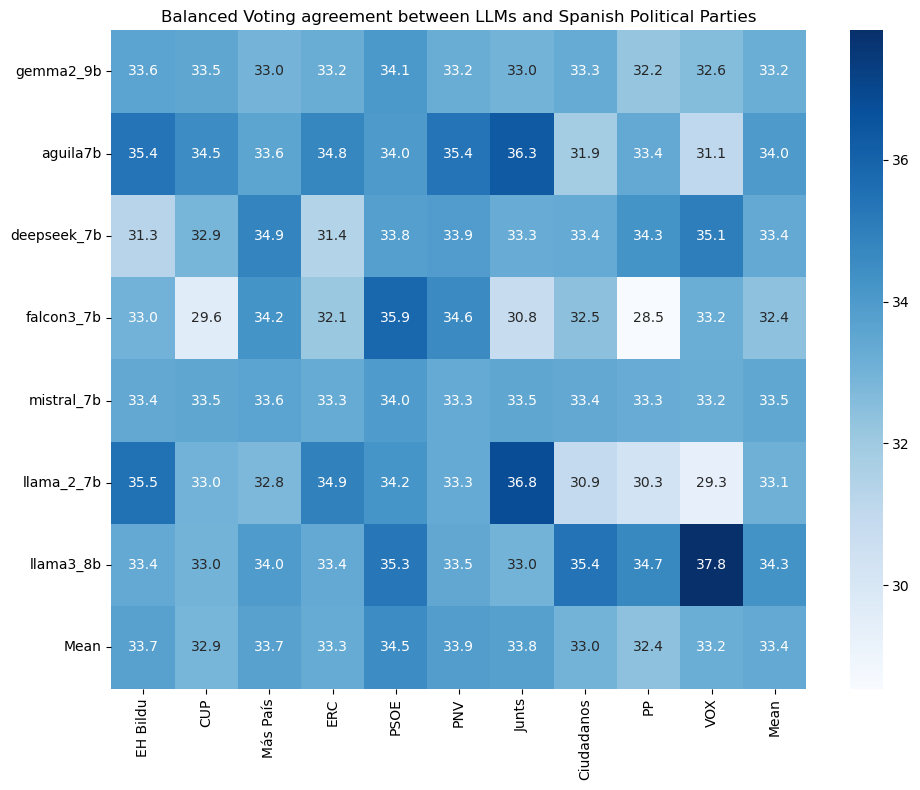

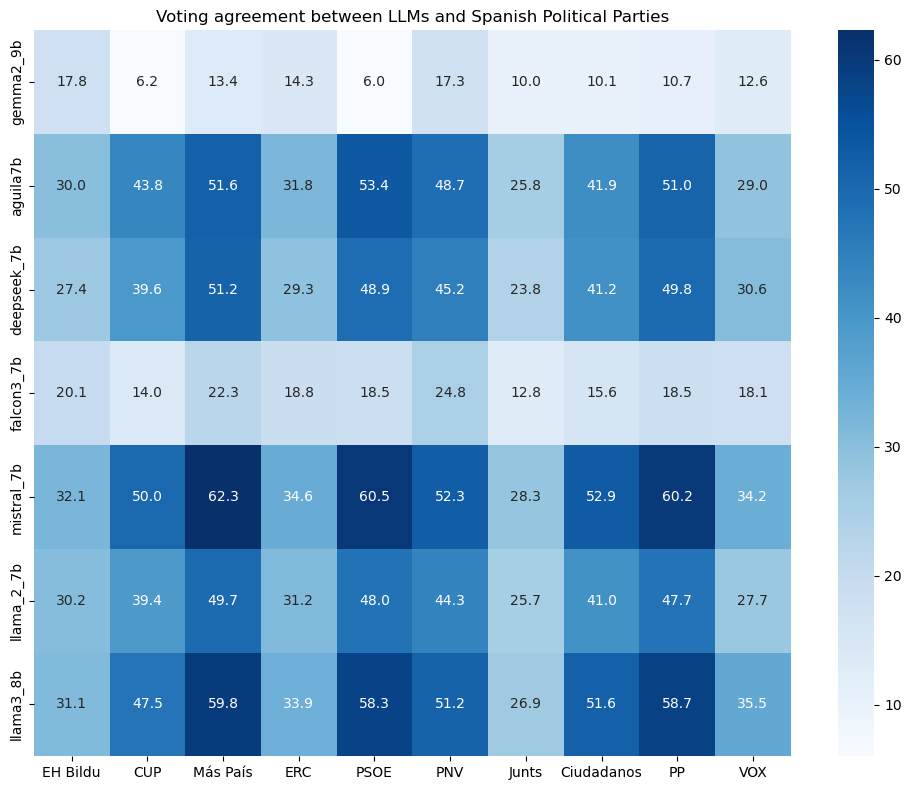

In [210]:
#################################################################################################################
# Computing and appends row and column means to the balanced accuracy matrix between LLMs and Spanish political #
# parties, then visualizes the extended matrix as a heatmap to summarize overall voting alignment.              #
#################################################################################################################

balanced_accuracy_df['Mean'] = balanced_accuracy_df.mean(axis=1).round(1)
balanced_accuracy_df.loc['Mean'] = balanced_accuracy_df.mean(axis=0).round(1)
print(balanced_accuracy_df)

balanced_accuracy_df = balanced_accuracy_df.astype(float)

heat_plot(
    balanced_accuracy_df,
    'Balanced Voting agreement between LLMs and Spanish Political Parties', 
    party_codes+['Mean'],
    model_names_short_list+['Mean'],
    f"heatmap_bal_agreement_{exp_var}"
)
heat_plot(
    agreement_df.astype(float),
    "Voting agreement between LLMs and Spanish Political Parties",
    party_codes,
    model_names_short_list,
    f"heatmap_agreement_{exp_var}"
)

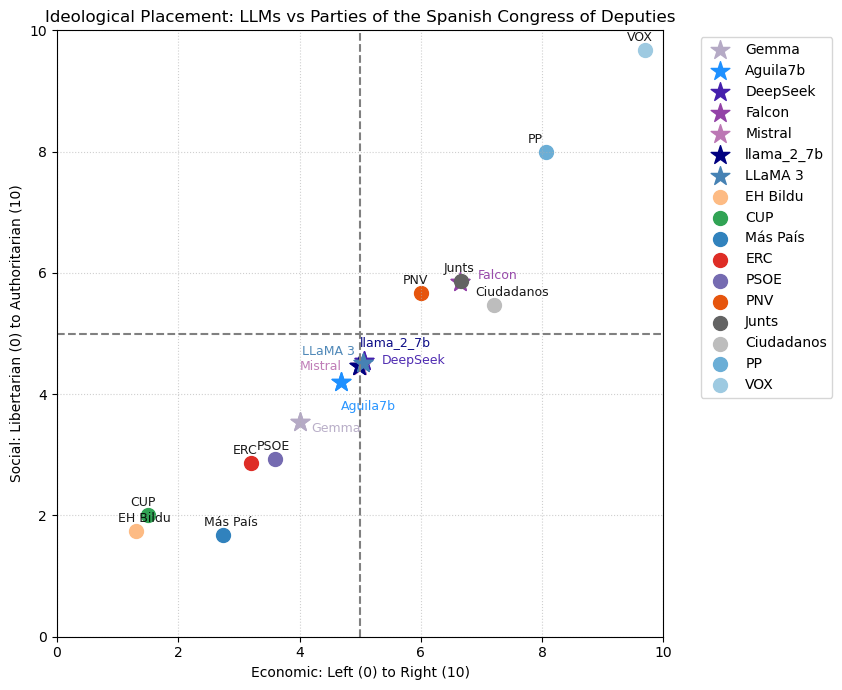

In [768]:
################################################################################################
# Computing and visualizing the ideological positions of Spanish political parties and LLMs by #
# projecting LLMs onto CHES coordinates using cosine similarity with party voting patterns.    #
################################################################################################

full_df = pd.read_csv("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/all_initiatives_with_ALL_party_&_llm_votes.csv")

party_cols = ['EH Bildu', 'CUP', 'Más País', 'ERC', 'PSOE', 'PNV', 'Junts', 'Ciudadanos', 'PP', 'VOX']
llm_cols = ['gemma2_9b', 'aguila7b', 'deepseek_7b', 'falcon3_7b', 'mistral_7b', 'llama_2_7b', 'llama3_8b']

vote_matrix = full_df[party_cols + llm_cols].fillna(0)

party_vectors = vote_matrix[party_cols].T
llm_vectors = vote_matrix[llm_cols].T

lrgen_dict = {'Ciudadanos': 7.2, 'Más País': 2.73, 'PNV': 6.0, 'PP': 8.07, 'PSOE': 3.6,
              'CUP': 1.5, 'ERC': 3.2, 'VOX': 9.7, 'EH Bildu': 1.3, 'Junts': 6.67}

galtan_dict = {'Ciudadanos': 5.47, 'Más País': 1.67, 'PNV': 5.67, 'PP': 8.0, 'PSOE': 2.93,
               'CUP': 2.0, 'ERC': 2.87, 'VOX': 9.67, 'EH Bildu': 1.75, 'Junts': 5.87}

lrgen_array = np.array([lrgen_dict[p] for p in party_cols])
galtan_array = np.array([galtan_dict[p] for p in party_cols])

similarities = cosine_similarity(llm_vectors, party_vectors)

llm_lrgen = similarities @ lrgen_array / similarities.sum(axis=1)
llm_galtan = similarities @ galtan_array / similarities.sum(axis=1)

llm_positions = pd.DataFrame({
    "lrgen": llm_lrgen,
    "galtan": llm_galtan
}, index=llm_cols)

colors_parties = [
    "#fdbb84", "#31a354", "#3182bd", "#de2d26", "#756bb1",
    "#e6550d", "#636363", "#bdbdbd", "#6baed6", "#9ecae1"
]
party_color_map = dict(zip(party_cols, colors_parties))

plt.figure(figsize=(8, 7))

model_names = llm_positions.index.tolist()

colors_models = [
    '#B5AAC5',
    '#1E90FF',
    '#4520AD',
    '#9342A7',
    '#BC77B4',
    '#000080',
    '#4682B4' 
]

label_map = {
    'gemma2_9b': 'Gemma',
    'aguila7b': 'Aguila7b',
    'deepseek_7b': 'DeepSeek',
    'falcon3_7b': 'Falcon',
    'mistral_7b': 'Mistral',
    'llama_2b_7b': 'LlaMA 2', 
    'llama3_8b': 'LLaMA 3',
} 

offsets = {
    'mistral_7b': (-1, 0), 
    'falcon3_7b': (0.3, 0.1),    
    'deepseek_7b': (0.3, 0),   
    'aguila7b': (0, -0.4),     
    'gemma2_9b': (0.2, -0.1), 
    'llama_2_7b': (0, 0.4),
    'llama3_8b': (-1, 0.2)   
}

for llm, color in zip(model_names, colors_models):
    x = llm_positions.loc[llm, 'lrgen']
    y = llm_positions.loc[llm, 'galtan']
    label = label_map.get(llm, llm)
    dx, dy = offsets.get(llm, (0.1, 0.1))

    plt.scatter(x, y, color=color, marker='*', s=200)

    plt.text(x + dx, y + dy, label, fontsize=9, color=color, alpha=0.95,
             ha='left', va='center')

    plt.scatter(x, y, color=color, marker='*', s=200, label=label)

for party in party_cols:
    x = lrgen_dict[party]
    y = galtan_dict[party]
    color = party_color_map[party]

    plt.scatter(x, y, color=color, s=100, marker='o', label=party)
    plt.text(x - 0.3, y + 0.15, party, fontsize=9, color='black', alpha=0.9)

plt.title("Ideological Placement: LLMs vs Parties of the Spanish Congress of Deputies")
plt.xlabel("Economic: Left (0) to Right (10)")
plt.ylabel("Social: Libertarian (0) to Authoritarian (10)")

handles, labels = plt.gca().get_legend_handles_labels()

llm_display_names = list(label_map.values())

party_entries = [(h, l) for h, l in zip(handles, labels) if l in party_cols]
llm_entries = [(h, l) for h, l in zip(handles, labels) if l in llm_display_names]

party_entries = sorted(party_entries, key=lambda x: party_cols.index(x[1]))
llm_entries = sorted(llm_entries, key=lambda x: llm_display_names.index(x[1]))

sorted_handles, sorted_labels = zip(*(party_entries + llm_entries))

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.axhline(y=5, color='gray', linestyle='--')
plt.axvline(x=5, color='gray', linestyle='--')
plt.xlabel("Economic: Left (0) to Right (10)")
plt.ylabel("Social: Libertarian (0) to Authoritarian (10)")
plt.title("Ideological Placement: LLMs vs Parties of the Spanish Congress of Deputies")
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# plt.savefig("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/results_latex/llm_vs_spanish_parties_good.png", dpi=600, bbox_inches='tight')

plt.show()